In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import pandas as pd
import pickle
import cmcrameri.cm as cmc

In [2]:
def get_scardec_stf(scardec_name, wanted_type = 'fctopt'):
    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [3]:
def get_ye_stf(ye_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/Ye_et_al_2016/'
    momentrate = []
    time = []

    with open(data_path + str(ye_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))
    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [4]:
def get_usgs_stf(usgs_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/USGS/'
    momentrate = []
    time = []

    with open(data_path + str(usgs_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)

    momentrate = momentrate / 10**7 # convert to Nm from dyne cm
    return momentrate, time

In [5]:
def get_sigloch_stf(sigloch_name):
    data_path = '/home/siglochnas1/shared/AmplitudeProjects/pdata_processed/psdata_events/'
    momentrate = []
    time = []

    file_path = data_path + str(sigloch_name) + '/outfiles/ampinv.stf.xy'

    with open(file_path, 'r') as file:
        content = file.read()
        content = content.split('\n')
        greater_than_count = content.count('>')
        if greater_than_count > 0:
            time = [list(np.arange(0, 25.6, 0.1))]
            momentrate = [[]]
            for i in range(greater_than_count-1):
                time.append(list(np.arange(0, 25.6, 0.1)))
                momentrate.append([])


        stf_count = 0
        for c in content:
            if c not in ['<', '>', '']:
                split = c.split()
                #time[stf_count].append(float(split[0]))
                momentrate[stf_count].append(10**float(split[1]))
            else:
                stf_count += 1

    # time = np.arange(0, 25.6, 0.1)
    # time = np.array(time)
    return momentrate, time

In [6]:
def get_isc_stf(isc_name):
    isc_save_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/isc/'
    with open(f'{isc_save_path}{isc_name}/{isc_name}.txt', 'rb') as f:
        stf_list = pickle.load(f)
    with open(f'{isc_save_path}{isc_name}/{isc_name}_norm_info.txt', 'rb') as f:
        norm_dict = pickle.load(f)

    time = np.arange(0, 25.6, 0.1)
    momentrate = np.array(stf_list)*norm_dict['mo_norm']*10**8,
    #print(momentrate)
    return momentrate[0], time

In [7]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')

In [8]:
combined.columns = ['event', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag']

In [9]:
def find_end_stf(momentrate, time, dataset = ''):
    not_zero = np.where(momentrate > 0)[0]
    #print(max(momentrate))
    start = min(not_zero)
    end = max(not_zero)

    detected_end = end
    detected_end_time = time[end]

    time = time[:end]
    momentrate = momentrate[:end]

    less_than_10 = np.where(momentrate <= 10*max(momentrate)/100)[0]

    if dataset == 'sigloch':
        start = np.where(momentrate > 0.05 * max(momentrate))[0][0]
    else:
        start = min(not_zero)
    #print(less_than_10)
    total_moment = scipy.integrate.simpson(momentrate[start:end],
                                        dx = time[1]-time[0])
    #print(less_than_10)
    for i in less_than_10:
        if i <= start:
            continue
        if i == 0:
            continue
        moment = scipy.integrate.simpson(momentrate[start:i],
                                        dx = time[1]-time[0])
        #print(i, moment/total_moment)
        if moment >= 0.5 * total_moment:
            #print('inif')
            #print(f'first time where < 10% of total momentrate and 50% of moment released: {time[i]} s')
            detected_end_time = time[i]
            detected_end = i
            #print(f'proportion of moment released: {(moment/total_moment)*100:.2f}%')
            break
    return detected_end_time, detected_end, time[start], start
    #return time[end], end

In [11]:
to_ignore = ['20051203_1610_1', '20071226_2204_2', '20030122_0206_1', '20090929_1748_0', '20120421_0125_1', '20110311_2011_2']

columns_to_save = ['event', 'dataset', 'mag', 'interp_momentrate']
df_interp = pd.DataFrame(columns = columns_to_save)
max_len = 0
for i, row in combined.iterrows():
	# if i < 360:
	# 	continue

	#fig, axs = plt.subplots(2, 1, figsize=(10, 10))


	for dataset, get_stf in zip(['scardec_opt', 'scardec_moy', 'ye', 'usgs', 'sigloch', 'isc'], [get_scardec_stf, get_scardec_stf, get_ye_stf, get_usgs_stf, get_sigloch_stf, get_isc_stf]):

		if dataset == 'scardec_moy' or dataset == 'scardec_opt':
			name = row[dataset[:-4]]
		else:
			name = row[dataset]

		if name == '0' or name == 0:
			continue

		if dataset == 'scardec_moy':
			momentrate, time = get_stf(name, 'fctmoy')
		elif dataset == 'scardec_opt':
			momentrate, time = get_stf(name, 'fctopt')
		else:
			momentrate, time = get_stf(name)

		if dataset != 'sigloch':
			momentrate_list = [momentrate]
			time_list = [time]
		else:
			momentrate_list = momentrate
			time_list = time

		count = 0
		for momentrate, time in zip(momentrate_list, time_list):
			if time[0] == time[1]:
				time = time[1:]

			if dataset != 'sigloch':
				save_key = row.event
				dataset_name = dataset
			else:
				dataset_name = dataset + '_' + str(count)
				save_key = row.event + '_' + str(count)

			if save_key in to_ignore:
				continue
			#print(time[0:10])
			
			momentrate = np.array(momentrate)

			time = np.array(time)
			detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(momentrate, time, dataset)
			time = time[detected_start:detected_end] # shift to start STF at zero
			time = time - time[0]
			momentrate = momentrate[detected_start:detected_end]
			max_len = max(max_len, len(momentrate))
			norm_momentrate = momentrate #/ max(momentrate)
			norm_time = time #/ max(time)
			#axs[0].plot(norm_time, norm_momentrate)

			interp_momentrate_stf = np.interp(np.linspace(0, max(time), int(max(time)*100)), norm_time, norm_momentrate)
			interp_momentrate = np.zeros(20000)
			if max(time) < 200:
				interp_momentrate[0:int(max(time)*100)] = interp_momentrate_stf
			else:
				interp_momentrate = interp_momentrate_stf[0:20000]
			interp_momentrate[interp_momentrate < 0] = 0

			#axs[1].plot(np.linspace(0, 1, 100), interp_momentrate)

			df_interp = pd.concat([df_interp, pd.DataFrame([[row.event, dataset_name, row.mag, interp_momentrate]], columns = columns_to_save)], ignore_index = True)
			count += 1
	#plt.show()
	#plt.close()
	# if i > 361:
	# 	break
	# 	break


In [96]:
time

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 1.855e+01, 1.856e+01,
       1.857e+01])

In [97]:
max_len

55209

In [98]:
df_interp

event      dataset    mag  \
0      20170818_0259  scardec_opt  6.591   
1      20170818_0259  scardec_moy  6.591   
2      20110126_1542  scardec_opt  6.114   
3      20110126_1542  scardec_moy  6.114   
4      20110126_1542    sigloch_0  6.114   
...              ...          ...    ...   
11757  20230206_1024         usgs    NaN   
11758  20231202_1437         usgs    NaN   
11759  19971108_1002         usgs    NaN   
11760  20181220_1701         usgs    NaN   
11761  20240628_0536         usgs    NaN   

                                       interp_momentrate  
0      [4.2217497e+16, 4.4202678924030616e+16, 4.6187...  
1      [1.01190503e+17, 1.0137817628652482e+17, 1.015...  
2      [9065991990000000.0, 9696722943678160.0, 1.032...  
3      [1703331550000000.0, 1662224864947707.2, 16211...  
4      [4.491460658796097e+16, 4.589560059255056e+16,...  
...                                                  ...  
11757  [975180.0, 4877478.976771538, 13655163.7753601...  
11758  [173140.0, 866695.1032847951, 2427250.35557060...  
11759  [1.7571684e+16, 1.969331785868171e+16, 2.18149...  
11760  [2.8159312e+16, 3.161310163125351e+16, 3.50668...  
11761  [201560.0, 1009554.60916442, 2827445.336927223...  

[11762 rows x 4 columns]

In [99]:
bigger_than = df_interp[((df_interp.mag > 5))]
filtered = bigger_than[bigger_than.mag < 6]

In [100]:
subset = filtered.interp_momentrate.values

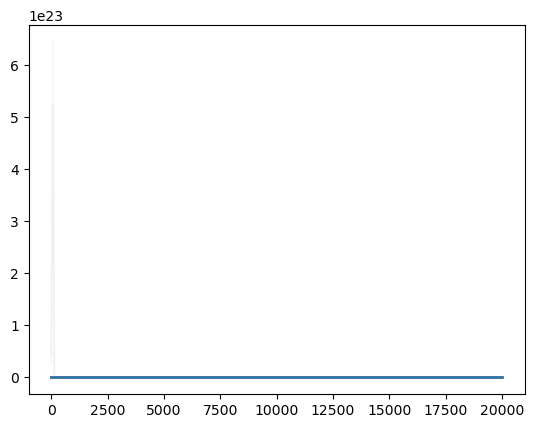

In [101]:
for s in subset:
	plt.plot(s, color = 'grey', alpha = 0.05)
plt.plot(subset.mean())

In [102]:
len(boundaries)

17

/tmp/ipykernel_549686/516076819.py:10: RuntimeWarning: Mean of empty slice.
  plt.plot(subset.mean())
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc5/lib/python3.10/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


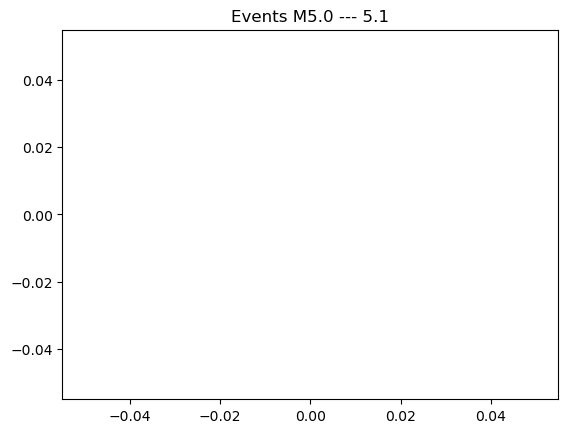

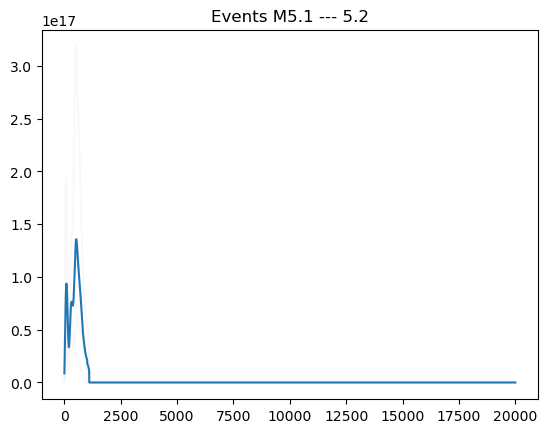

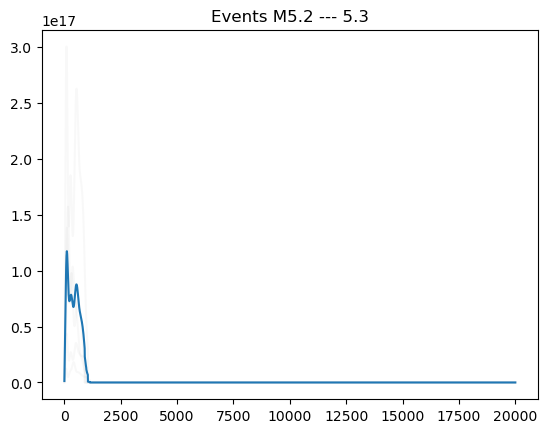

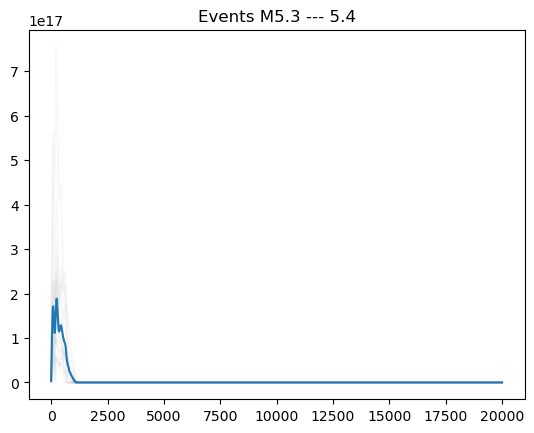

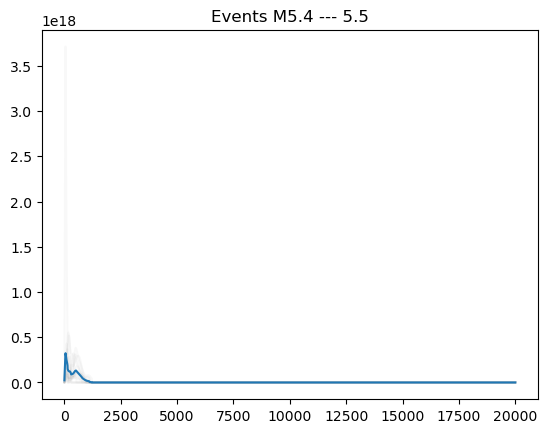

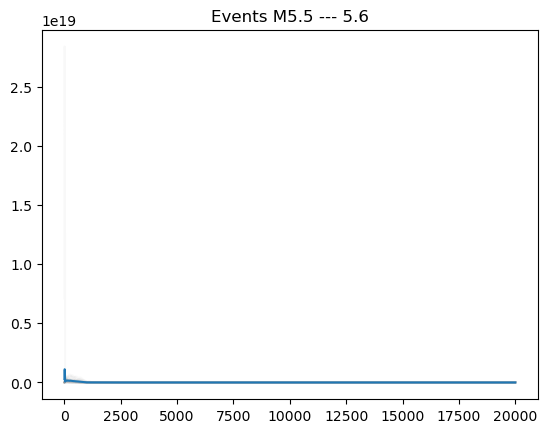

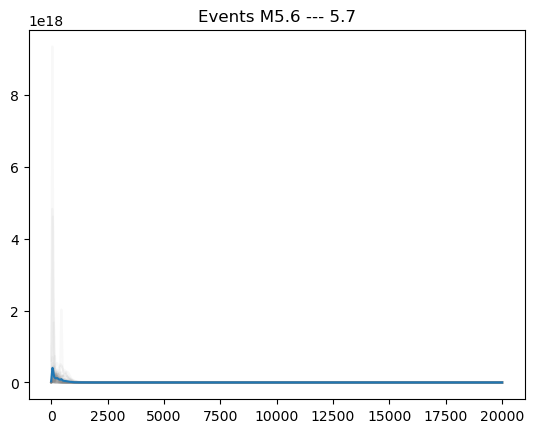

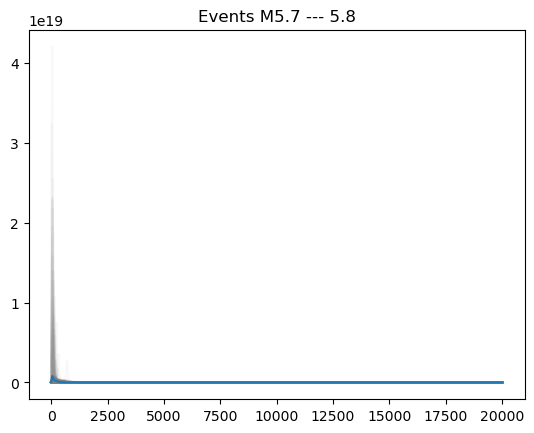

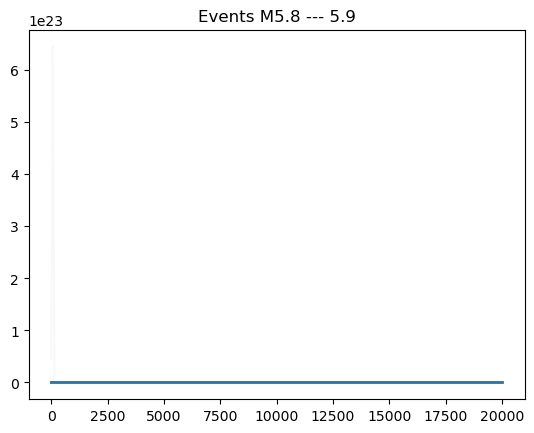

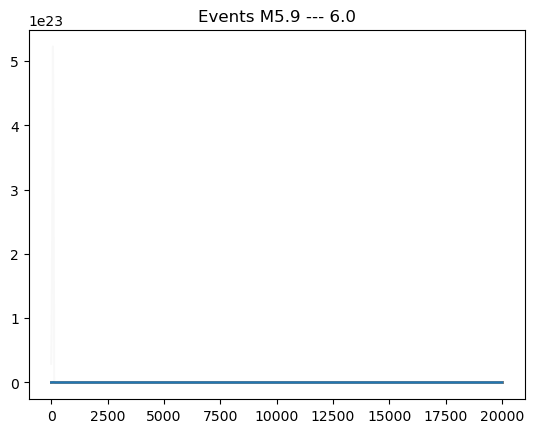

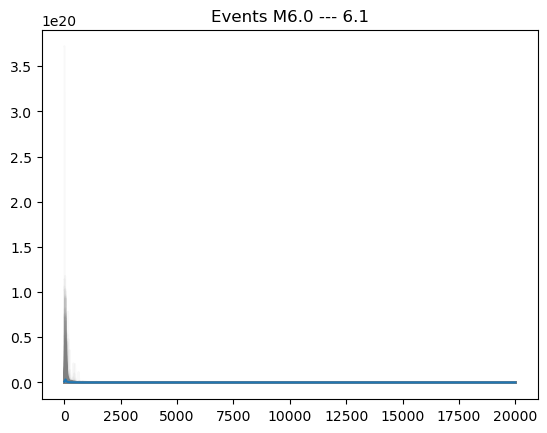

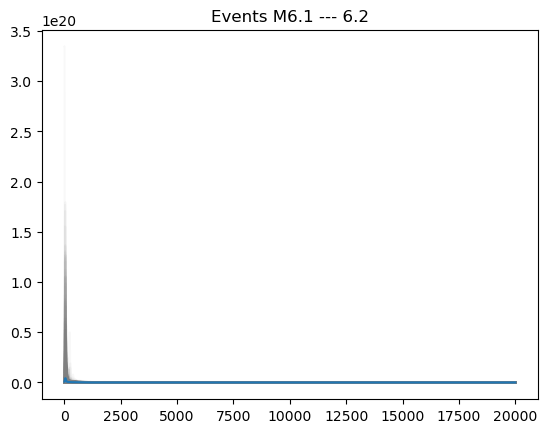

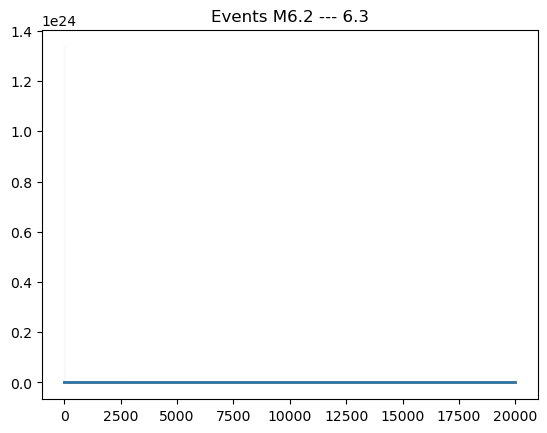

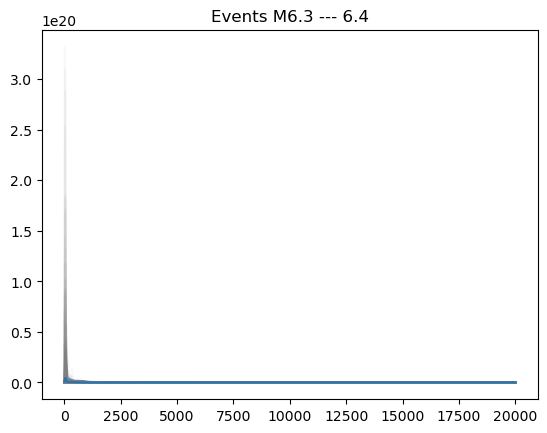

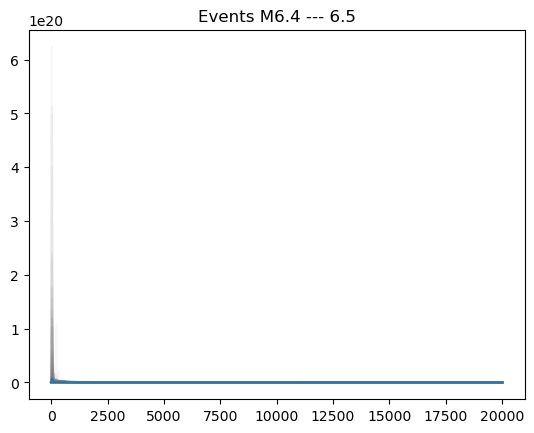

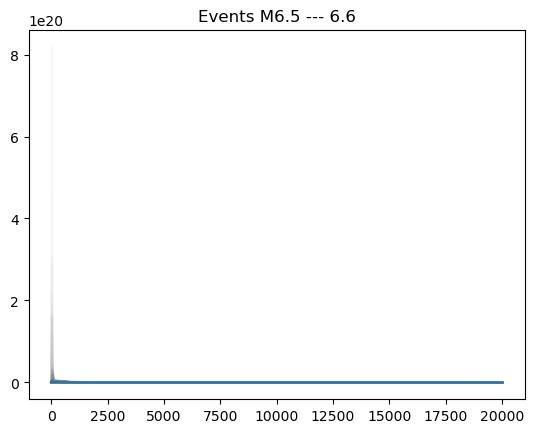

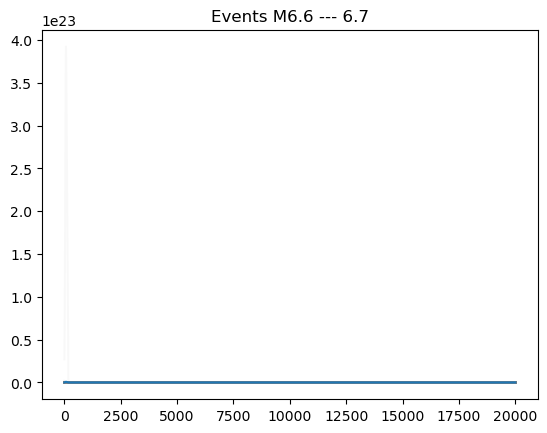

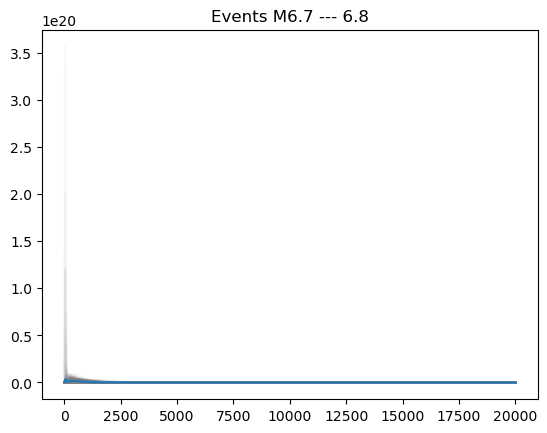

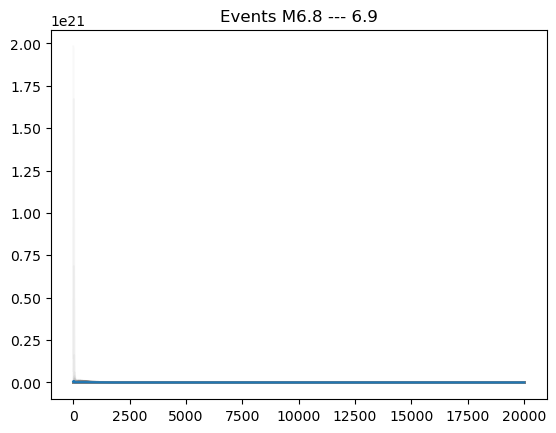

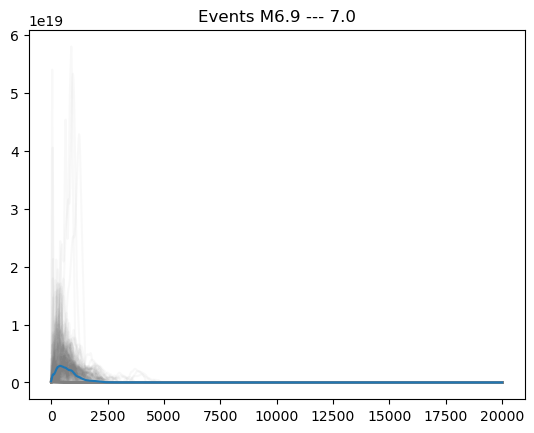

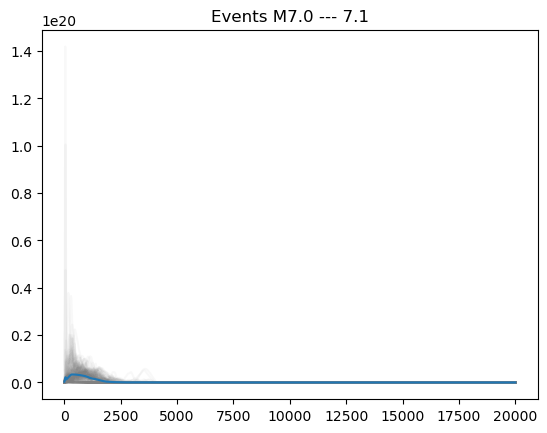

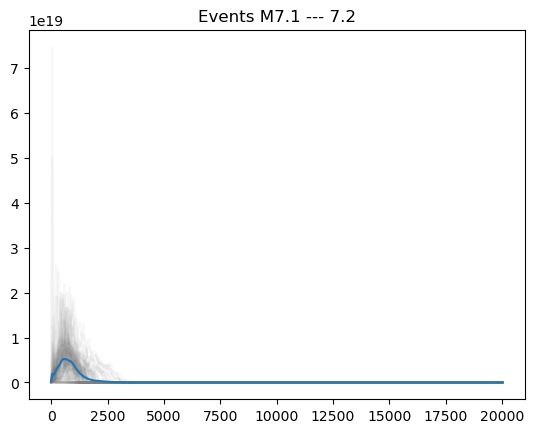

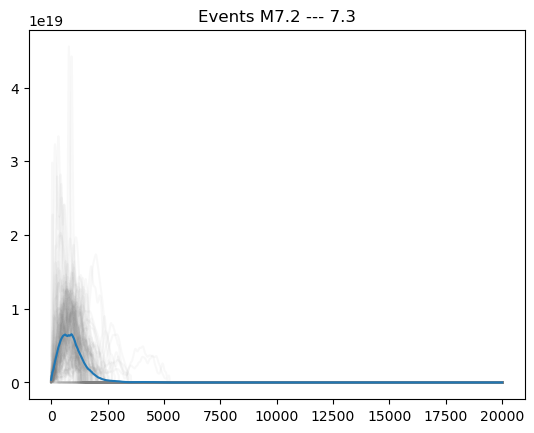

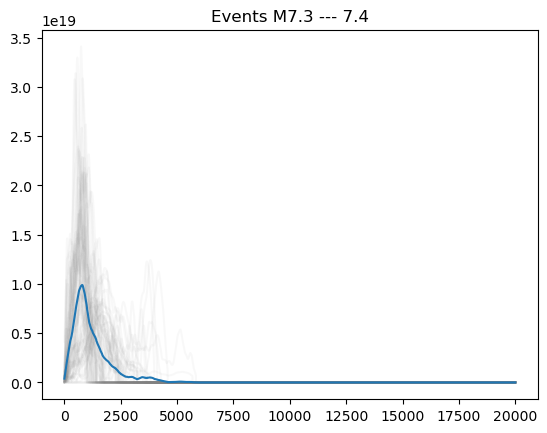

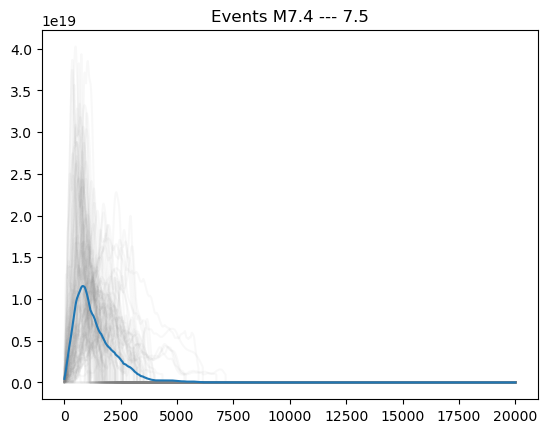

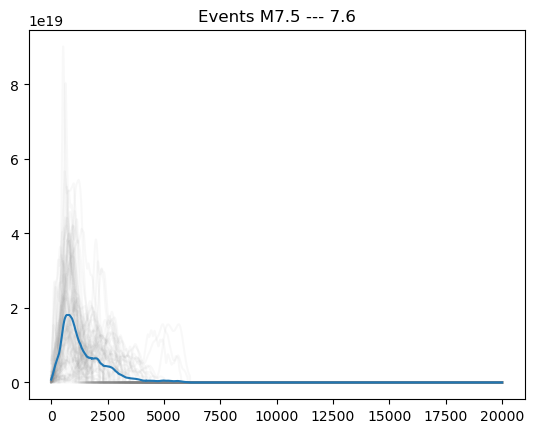

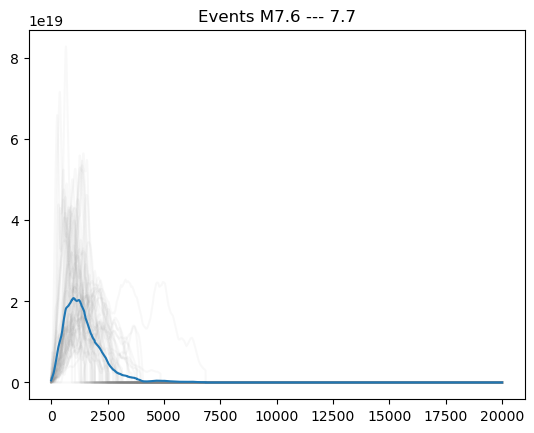

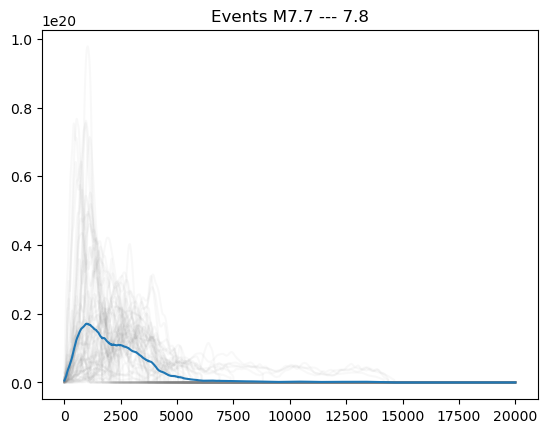

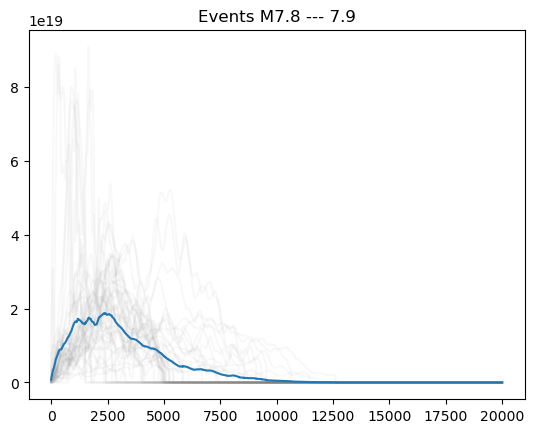

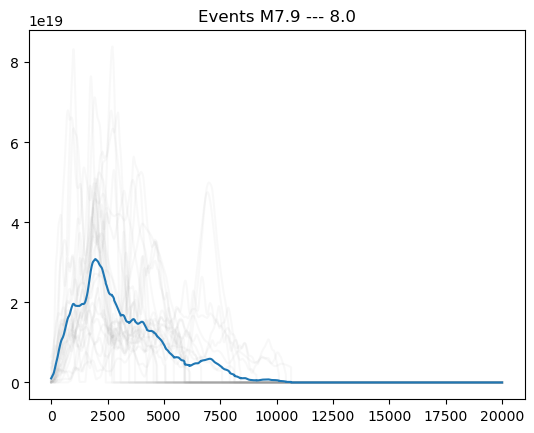

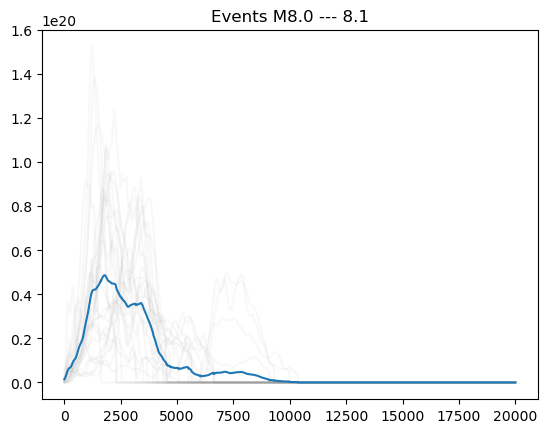

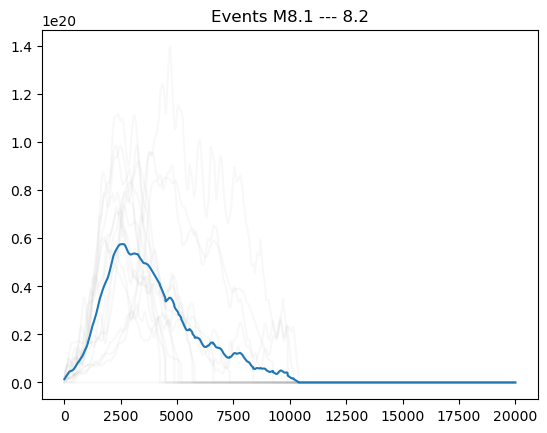

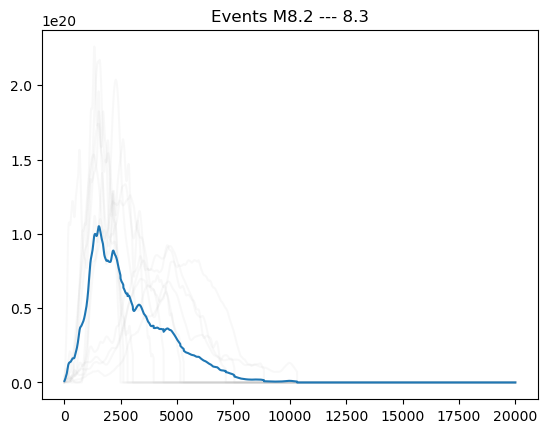

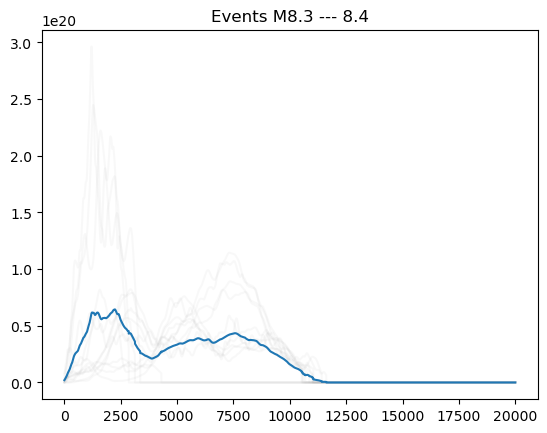

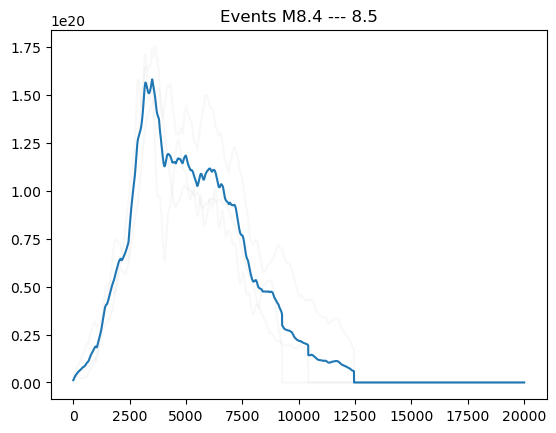

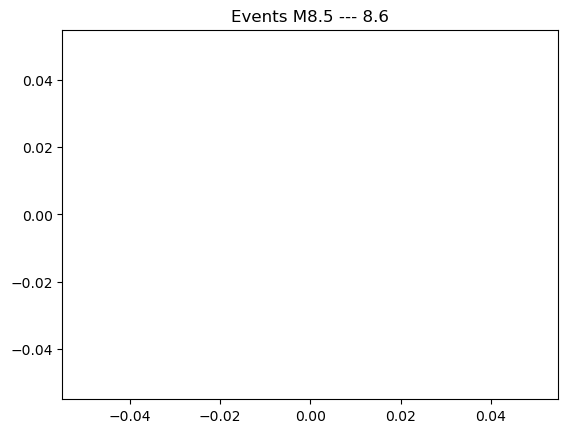

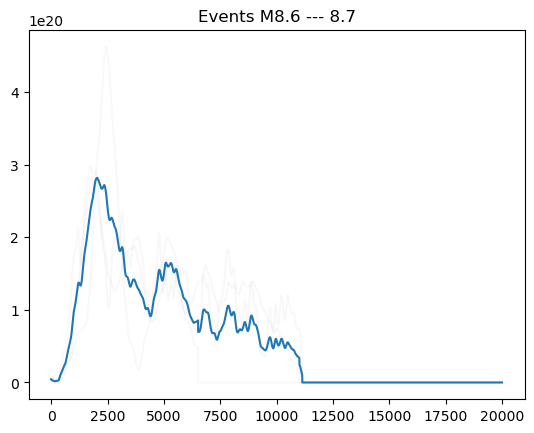

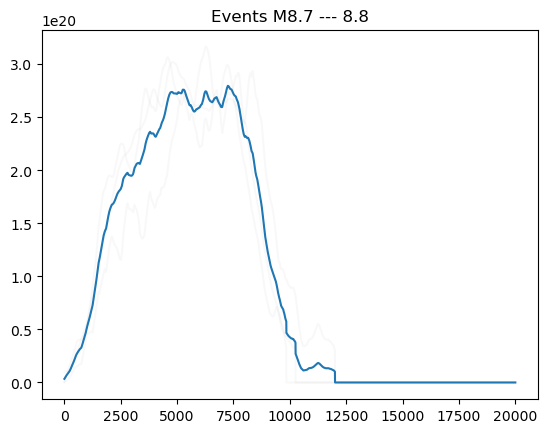

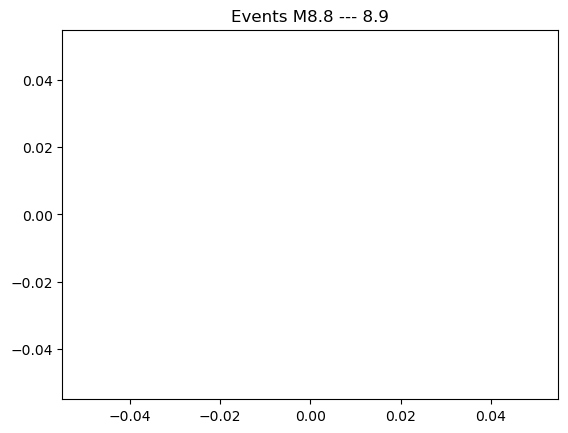

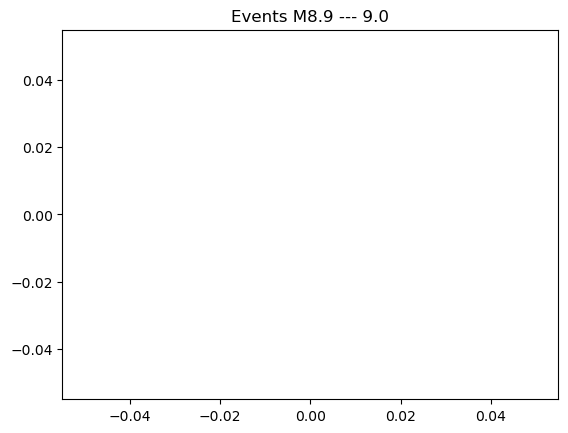

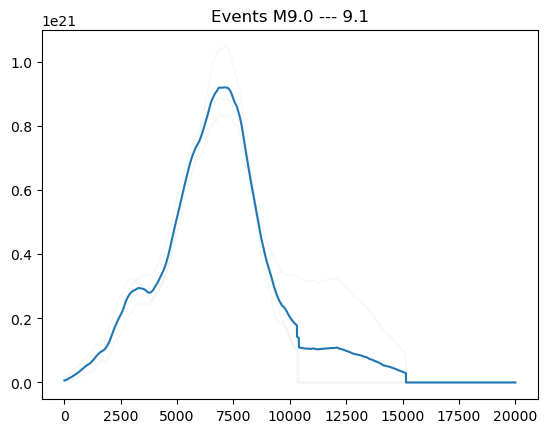

In [103]:
boundaries = np.arange(5, 9.1, 0.1)

for b in boundaries:
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+0.1]
	
	subset = filtered.interp_momentrate.values
	for s in subset:
		plt.plot(s, color = 'grey', alpha = 0.05)
	plt.plot(subset.mean())

	plt.title(f'Events M{b:.1f} --- {b+0.1:.1f}')

	plt.show()
	plt.close()


In [104]:
boundaries = np.arange(5, 8.6, 0.1)

In [105]:
len(boundaries)

36

In [106]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [107]:
list(subset)

[array([1.30476417e+19, 1.30689998e+19, 1.30903578e+19, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([5.44781898e+18, 5.45585072e+18, 5.46388245e+18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([7.35980000e+17, 7.50699372e+17, 7.65418743e+17, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00])]

In [108]:
np.median(list(subset), axis = 0)

array([5.44781898e+18, 5.45585072e+18, 5.46388245e+18, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [12]:
df_interp_all = df_interp.copy()

In [110]:
df_interp_all

event      dataset    mag  \
0      20170818_0259  scardec_opt  6.591   
1      20170818_0259  scardec_moy  6.591   
2      20110126_1542  scardec_opt  6.114   
3      20110126_1542  scardec_moy  6.114   
4      20110126_1542    sigloch_0  6.114   
...              ...          ...    ...   
11757  20230206_1024         usgs    NaN   
11758  20231202_1437         usgs    NaN   
11759  19971108_1002         usgs    NaN   
11760  20181220_1701         usgs    NaN   
11761  20240628_0536         usgs    NaN   

                                       interp_momentrate  
0      [4.2217497e+16, 4.4202678924030616e+16, 4.6187...  
1      [1.01190503e+17, 1.0137817628652482e+17, 1.015...  
2      [9065991990000000.0, 9696722943678160.0, 1.032...  
3      [1703331550000000.0, 1662224864947707.2, 16211...  
4      [4.491460658796097e+16, 4.589560059255056e+16,...  
...                                                  ...  
11757  [975180.0, 4877478.976771538, 13655163.7753601...  
11758  [173140.0, 866695.1032847951, 2427250.35557060...  
11759  [1.7571684e+16, 1.969331785868171e+16, 2.18149...  
11760  [2.8159312e+16, 3.161310163125351e+16, 3.50668...  
11761  [201560.0, 1009554.60916442, 2827445.336927223...  

[11762 rows x 4 columns]

In [111]:
df_interp_all['dataset'].str.contains('usgs')

0        False
1        False
2        False
3        False
4        False
         ...  
11757     True
11758     True
11759     True
11760     True
11761     True
Name: dataset, Length: 11762, dtype: bool

In [112]:
df_interp_all[df_interp_all['dataset'].str.contains('sigloch')]

event    dataset     mag  \
4      20110126_1542  sigloch_0  6.1140   
13     20011012_1502  sigloch_0  6.9675   
14     20011012_1502  sigloch_1  6.9675   
15     20011012_1502  sigloch_2  6.9675   
24     20070402_1202  sigloch_0  6.2195   
...              ...        ...     ...   
11723  20040716_2358  sigloch_1  6.1000   
11724  20160812_0329  sigloch_0  6.1000   
11725  20090104_0714  sigloch_0  5.9000   
11726  20090104_0714  sigloch_1  5.9000   
11727  20091203_0612  sigloch_0  6.0000   

                                       interp_momentrate  
4      [4.491460658796097e+16, 4.589560059255056e+16,...  
13     [1.3053590967062318e+18, 1.4306052163926423e+1...  
14     [9448220061190.312, 9908854777934.387, 1036948...  
15     [38661615736.73813, 38648674050.02094, 3863573...  
24     [1.186697425011205e+18, 1.2611164913402593e+18...  
...                                                  ...  
11723  [21989228892408.332, 21987250827873.465, 21985...  
11724  [2.2144914100094932e+16, 2.2778796161541424e+1...  
11725  [4.053405010494197e+17, 4.2726872332513216e+17...  
11726  [17304139198085.684, 18356880276347.184, 19409...  
11727  [1.0171282109015933e+18, 1.065354249039238e+18...  

[3094 rows x 4 columns]

/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc5/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc5/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


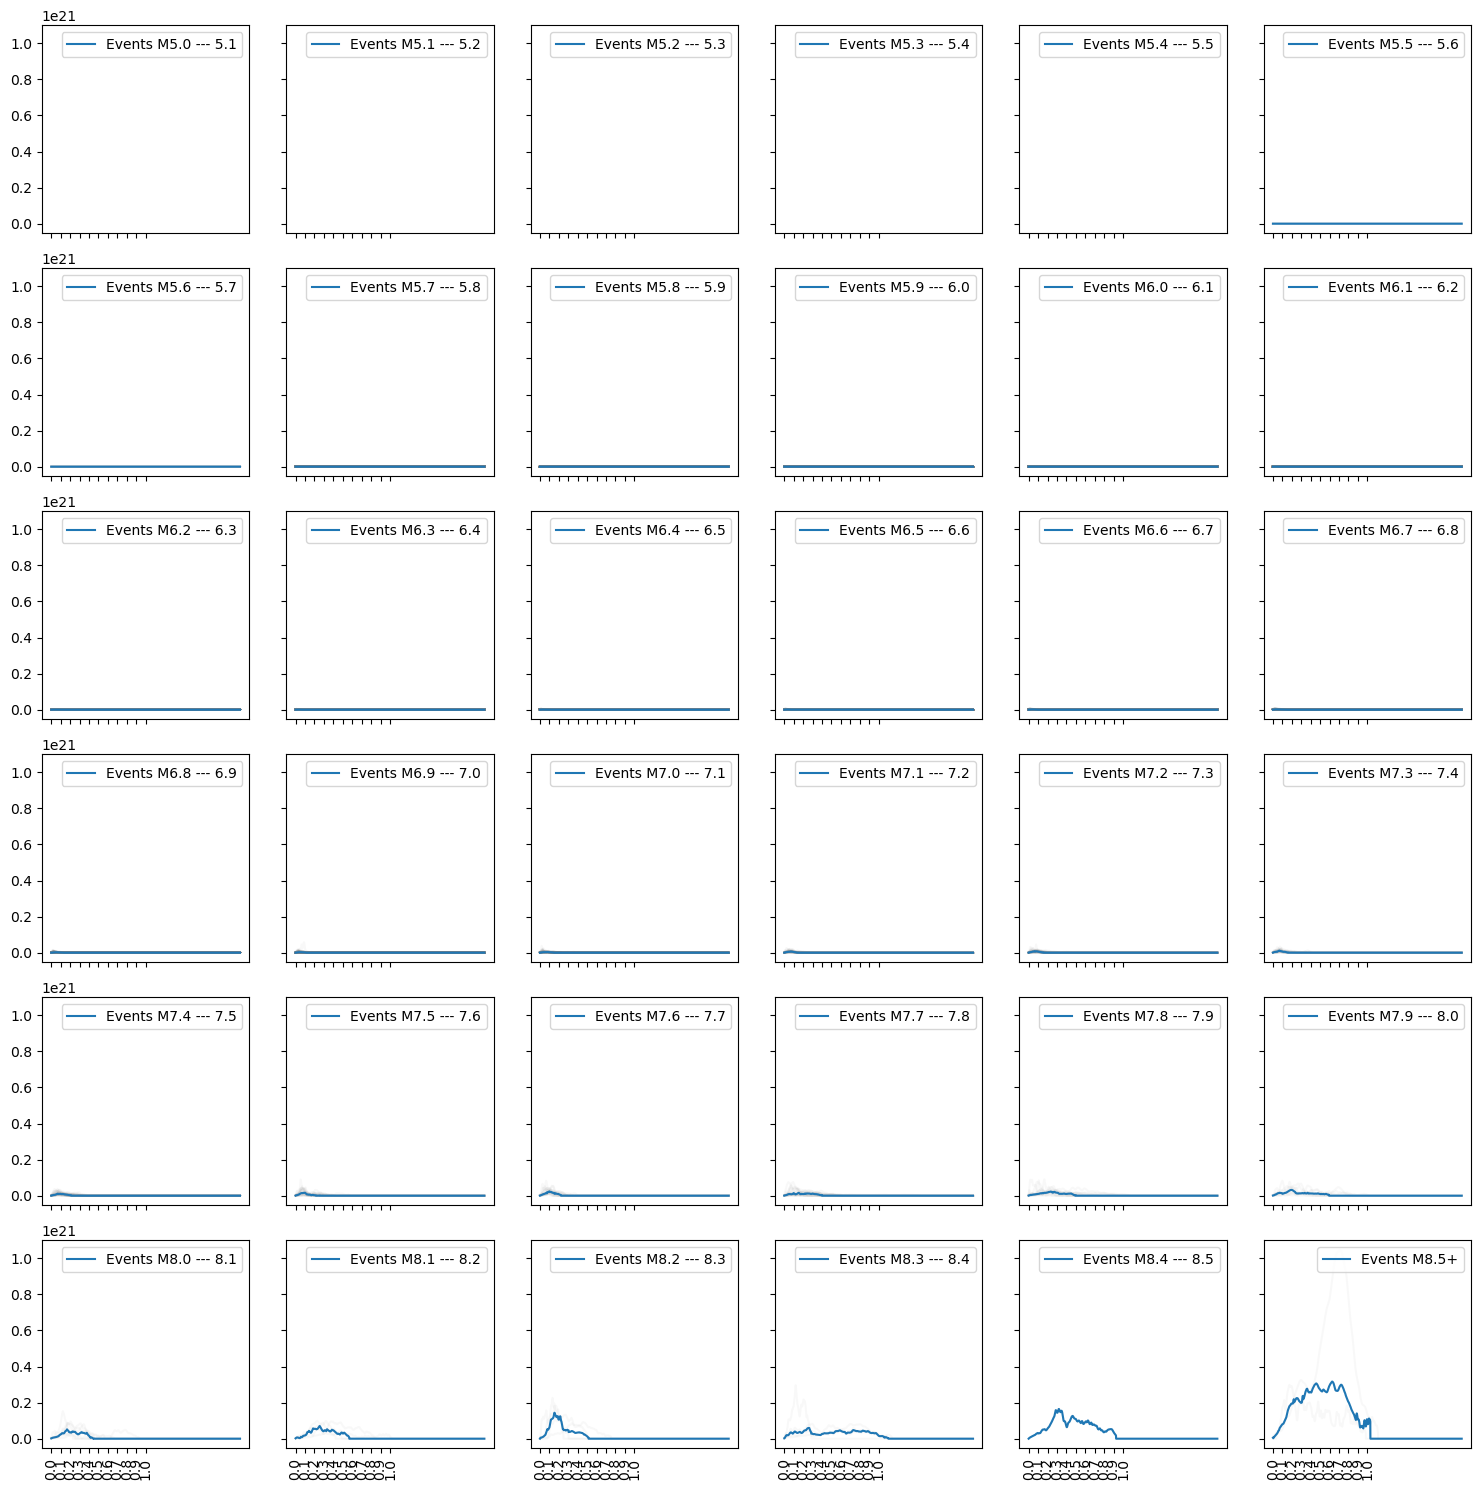

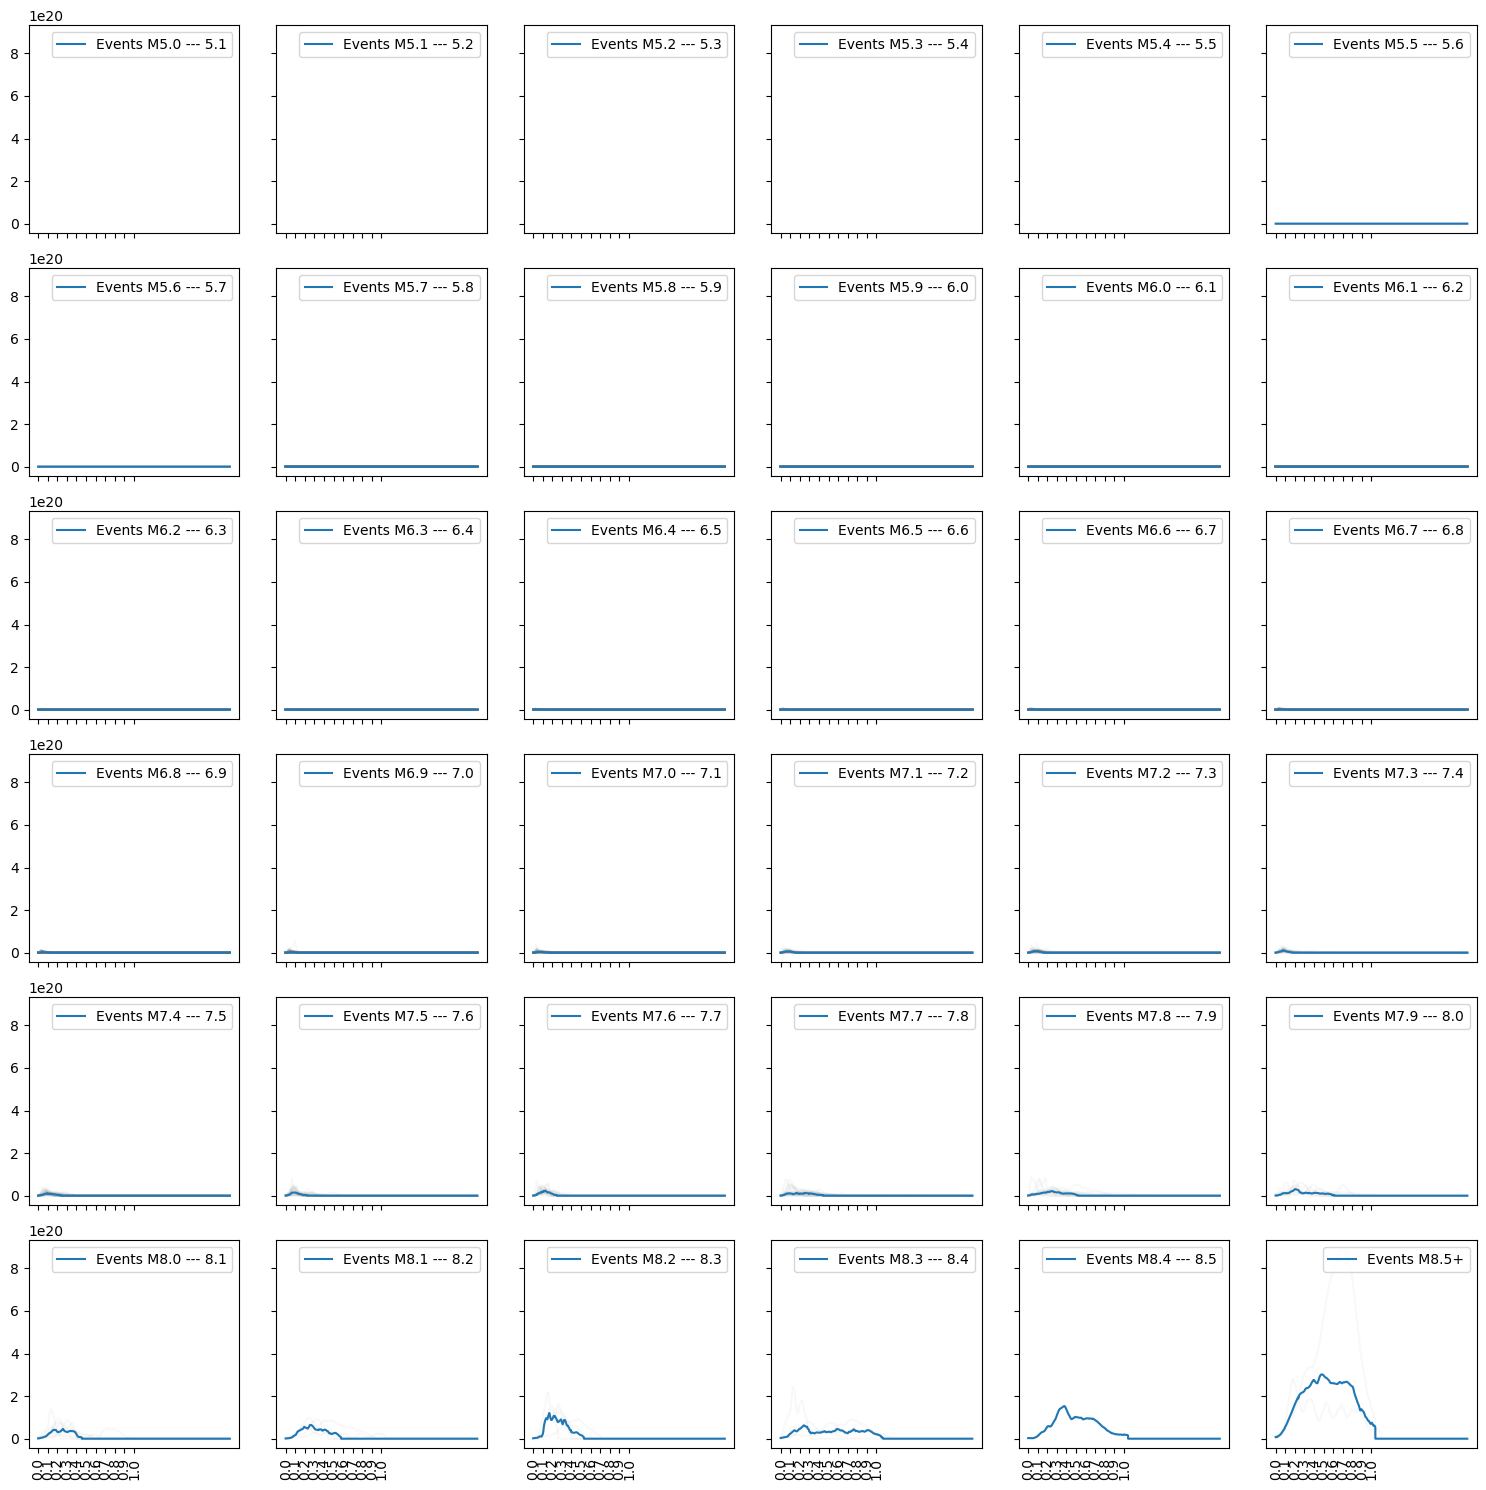

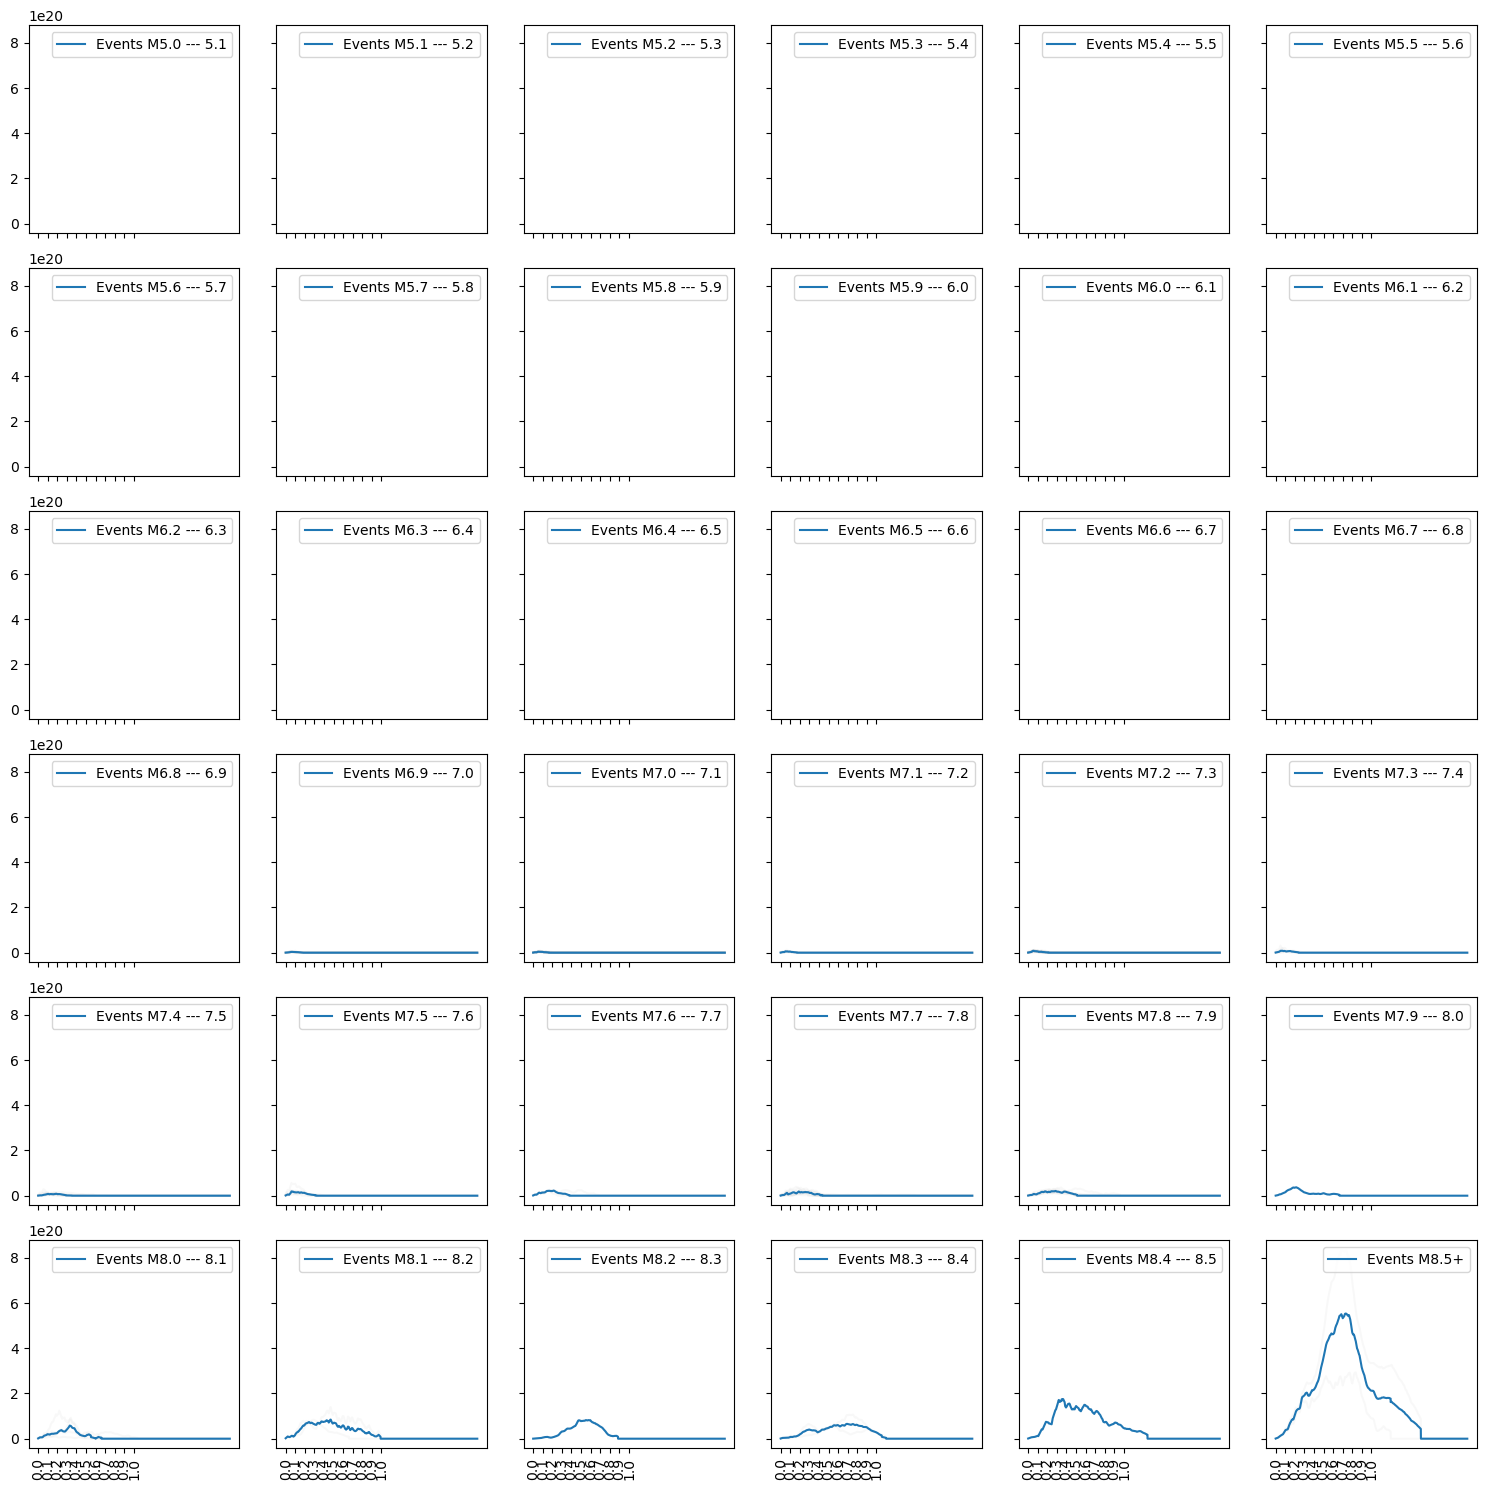

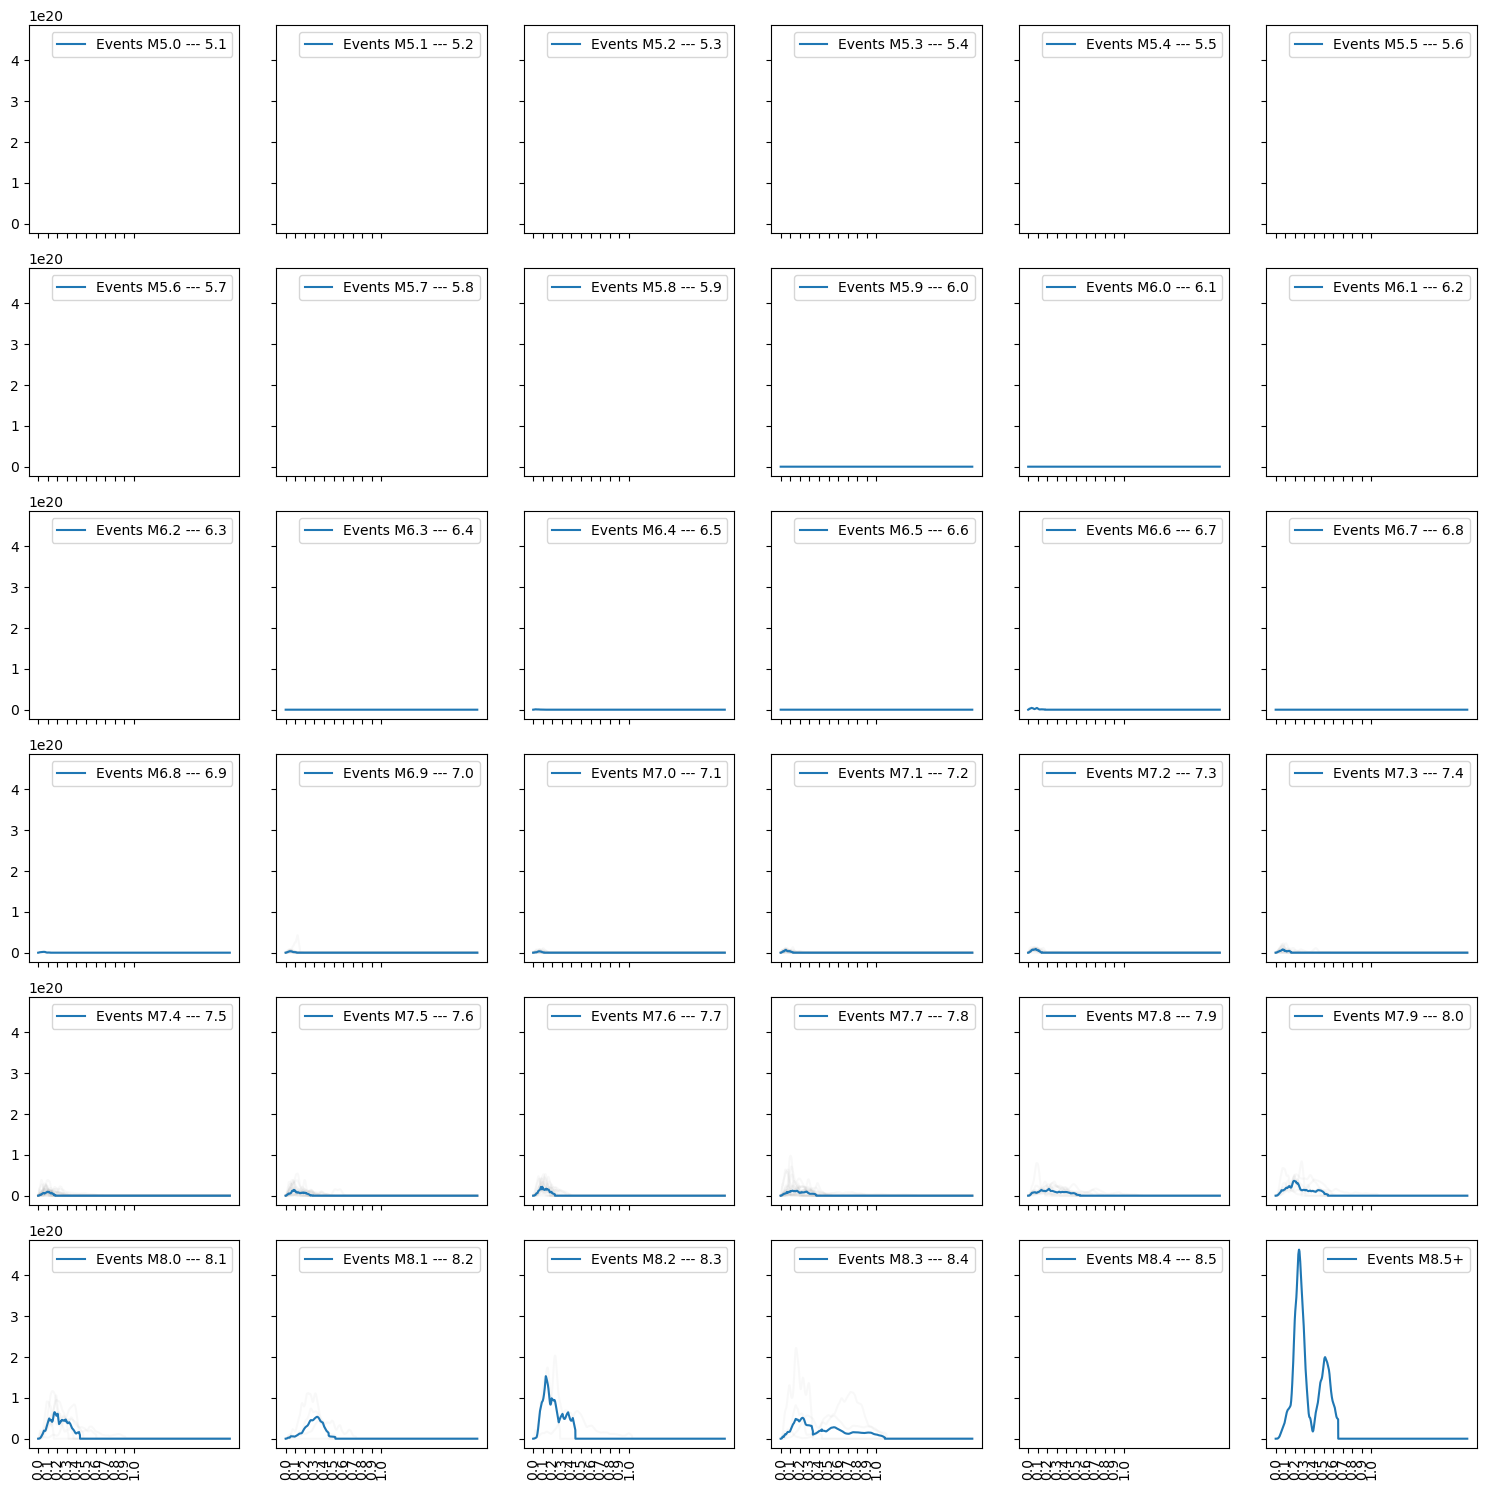

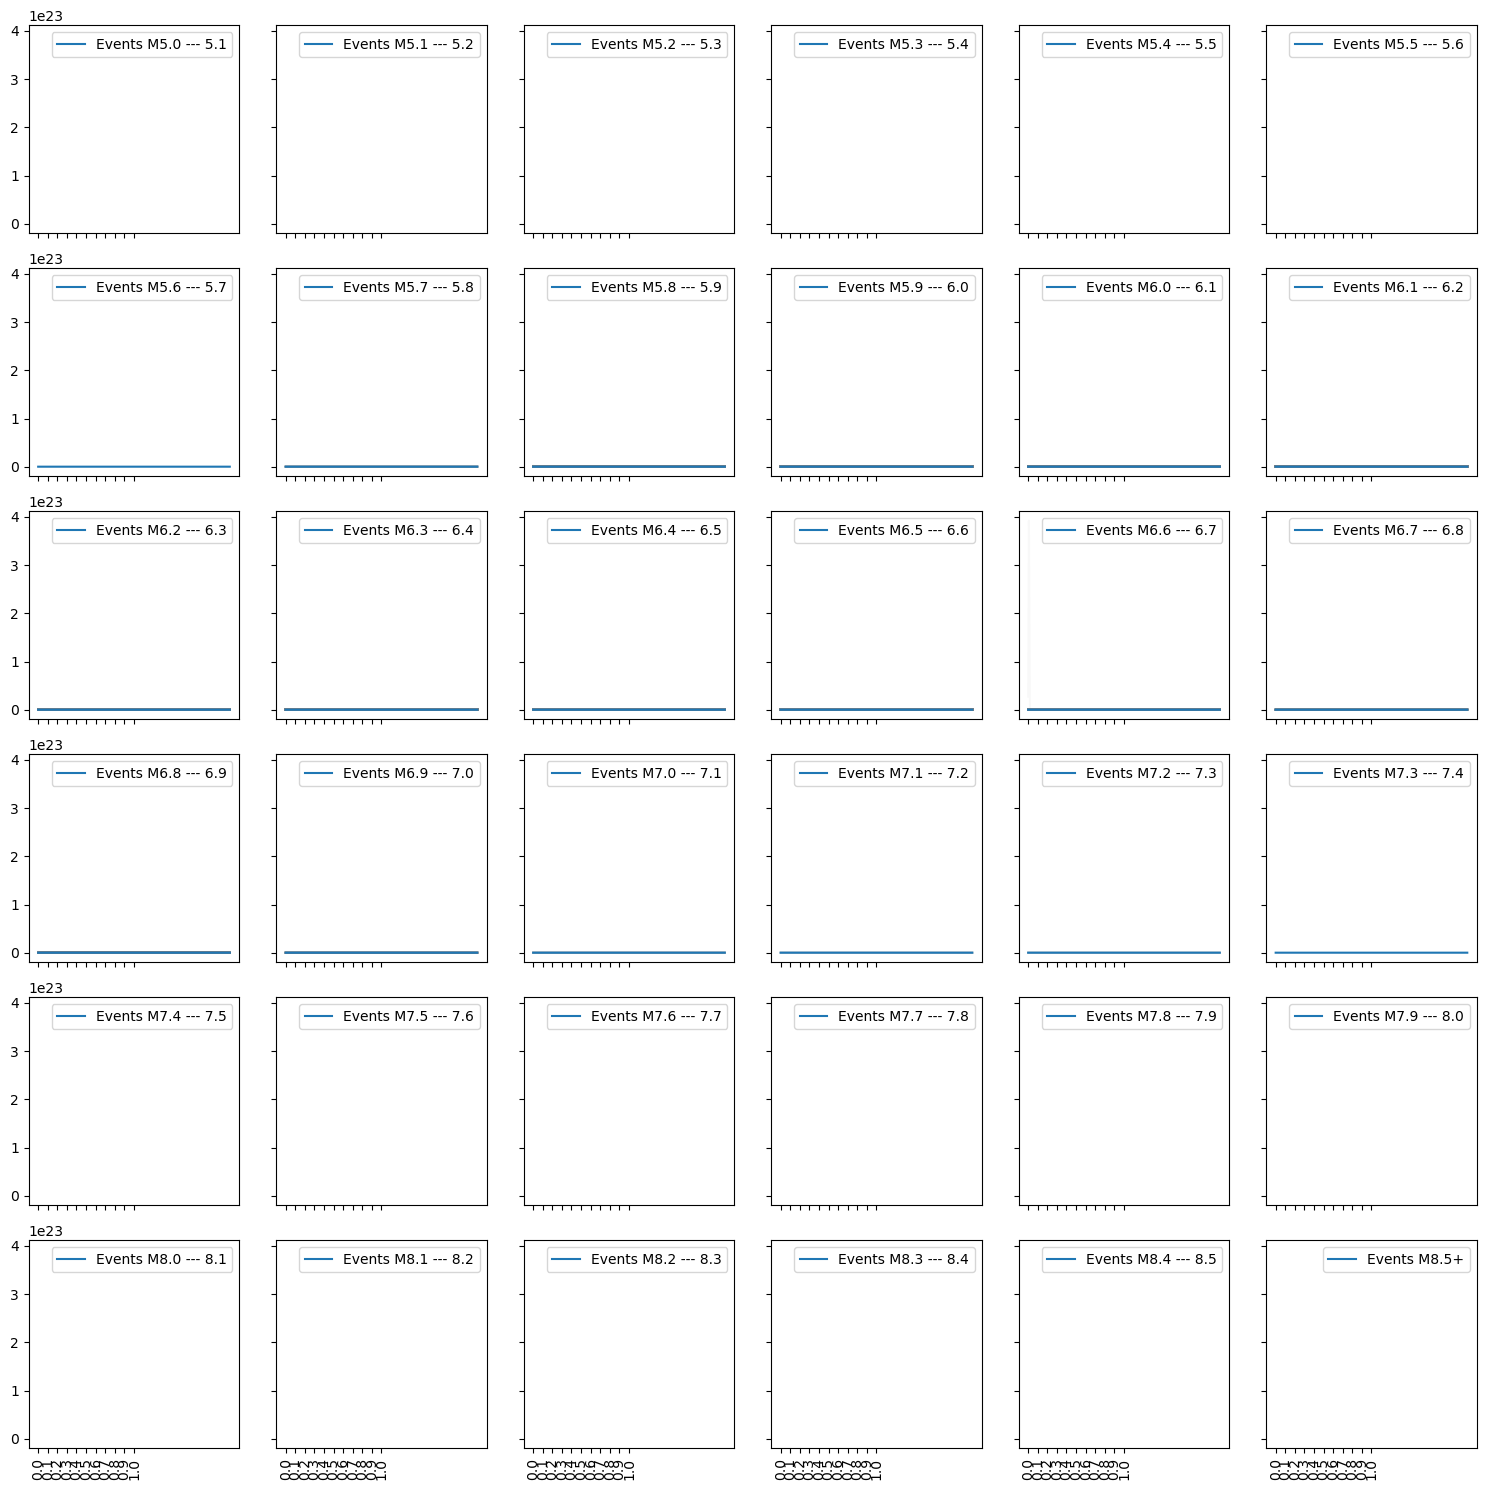

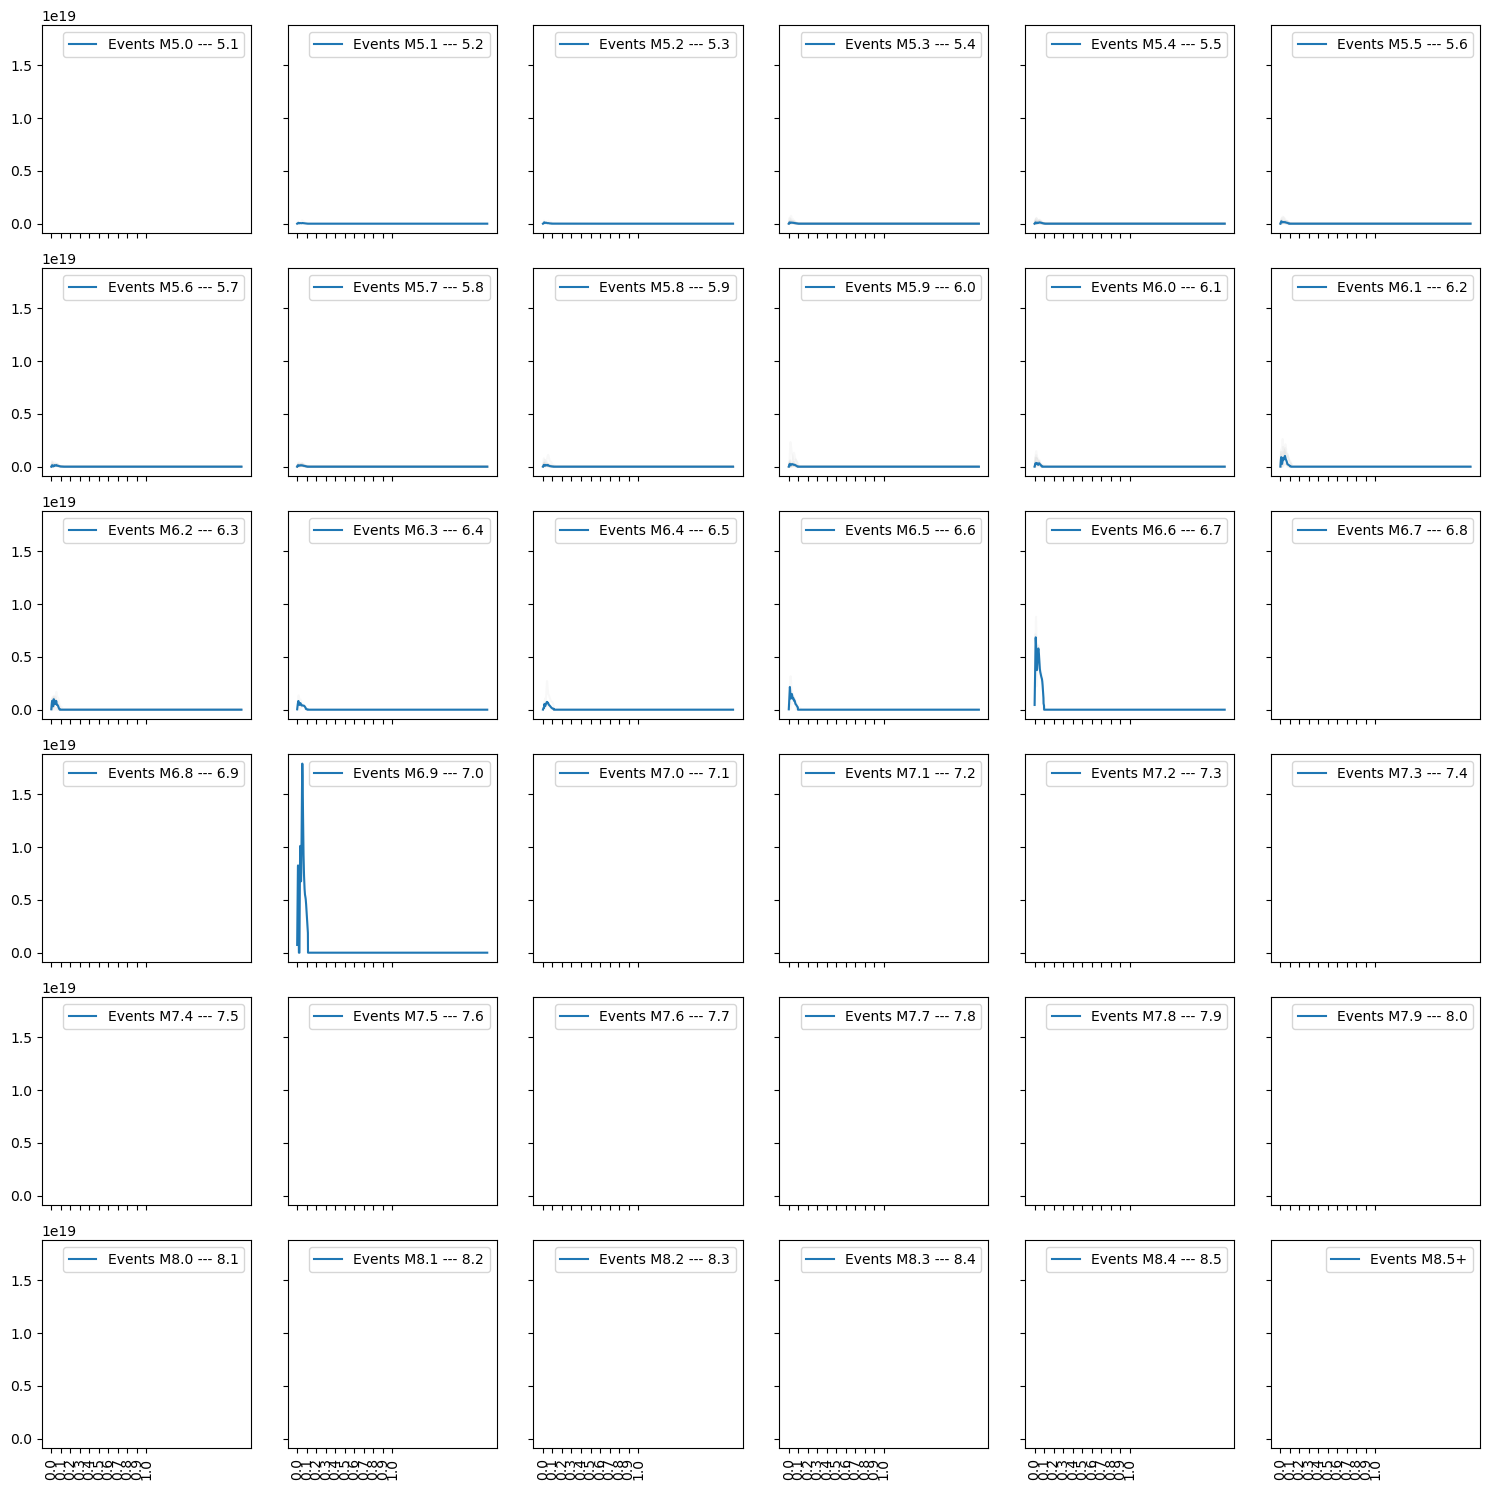

In [113]:
boundaries = np.arange(5, 8.6, 0.1)
ticks = np.arange(0, 1.1, 0.1)
ticks = list(map(lambda x: round(x, 1), ticks))
for dataset in ['scardec_opt', 'scardec_moy', 'ye', 'usgs', 'sigloch', 'isc']:
	fig, axs = plt.subplots(6, 6, figsize=(15, 15), sharex = True, sharey = True)
	df_interp = df_interp_all[df_interp_all['dataset'].str.contains(dataset)]
	for i, b in enumerate(boundaries):
		b = round(b, 1)

		ax = axs[i//6, i%6]
		bigger_than = df_interp[((df_interp.mag > b))]
		if b == 8.5:
			filtered = bigger_than
			subset = filtered.interp_momentrate.values
			for s in subset:
				ax.plot(s, color = 'grey', alpha = 0.05)
			ax.plot(np.median(list(subset), axis = 0), label = f'Events M{b:.1f}+')
		else:
			filtered = bigger_than[bigger_than.mag < b+0.1]
			subset = filtered.interp_momentrate.values
			for s in subset:
				ax.plot(s, color = 'grey', alpha = 0.05)
			ax.plot(np.median(list(subset), axis = 0), label = f'Events M{b:.1f} --- {b+0.1:.1f}')

		

		ax.set_xticks(np.linspace(0, 10000, 11), ticks, rotation = 90)
		ax.legend(loc = 'upper right')
			
	plt.tight_layout()

	plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/median_stf_by_mag_{dataset}.png', bbox_inches = 'tight', dpi = 300)
	plt.show()
	plt.close()


5.0 0.0122 5
5.2 0.009 33
5.5 0.0205 204
5.8 0.0199 2977
6.0 0.0228 3029
6.2 0.0295 2129
6.5 0.0382 1227
6.8 0.0514 824
7.0 0.0613 434


/tmp/ipykernel_615670/3647921929.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))


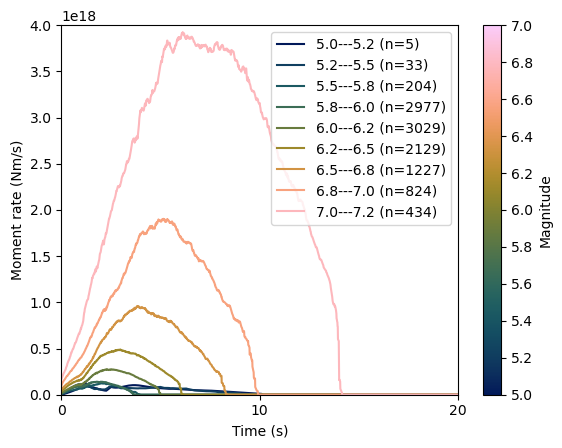

In [24]:
interval = 0.25
boundaries = np.arange(5, 7.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0), label = f'{b:.1f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))
cbar.ax.set_yticklabels([f'{b:.1f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=11)])
cbar.set_label('Magnitude')

# plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 1000), np.arange(0, 200, 10))



plt.xlim(0, 2000)
plt.ylim(0, 4E18)
# plt.yscale('log')
plt.legend()


plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_M5_to_7.png', bbox_inches = 'tight', dpi = 300)



5.5 0.0205 204
5.8 0.0199 2977
6.0 0.0228 3029
6.2 0.0295 2129
6.5 0.0382 1227
6.8 0.0514 824
7.0 0.0613 434


/tmp/ipykernel_615670/239494861.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))


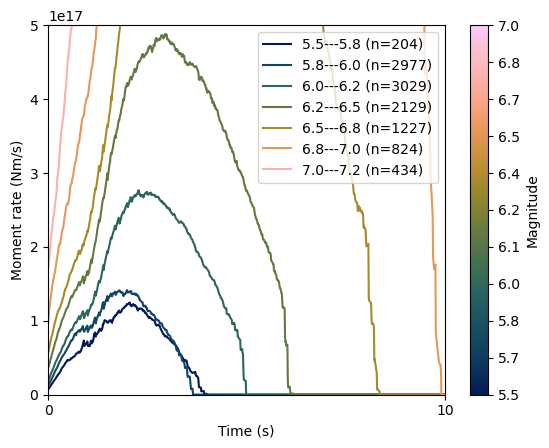

In [25]:
interval = 0.25
boundaries = np.arange(5.5, 7.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0), label = f'{b:.1f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))
cbar.ax.set_yticklabels([f'{b:.1f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=11)])
cbar.set_label('Magnitude')

# plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 1000), np.arange(0, 200, 10))



plt.xlim(0, 1000)
plt.ylim(0, 5E17)
# plt.yscale('log')
plt.legend()


plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_M5_to_7_zooom.png', bbox_inches = 'tight', dpi = 300)



5.0 0.0122 5
5.2 0.009 33
5.5 0.0205 204
5.8 0.0199 2977
6.0 0.0228 3029
6.2 0.0295 2129
6.5 0.0382 1227
6.8 0.0514 824
7.0 0.0613 434
7.2 0.0903 242
7.5 0.0879 175
7.8 0.2136 111
8.0 0.2069 48
8.2 0.3048 24
8.5 0.199 3
8.8 0.4702 3
9.0 0.6918 3


/tmp/ipykernel_615670/2375745319.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))


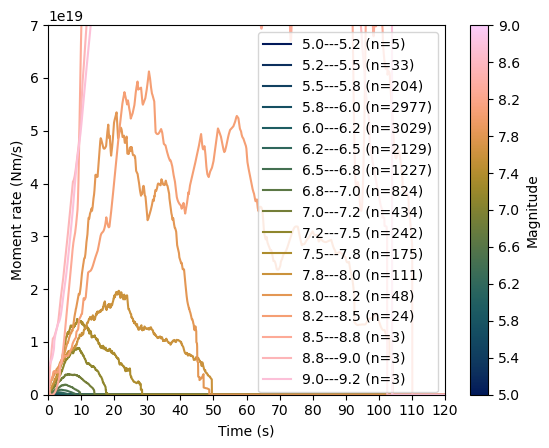

In [26]:
interval = 0.25
boundaries = np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0), label = f'{b:.1f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))
cbar.ax.set_yticklabels([f'{b:.1f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=11)])
cbar.set_label('Magnitude')

# plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 1000), np.arange(0, 200, 10))



plt.xlim(0, 12000)
plt.ylim(0, 7E19)
plt.legend()
# plt.yscale('log')


plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_all_mags.png', bbox_inches = 'tight', dpi = 300)



In [117]:
max(boundaries)

9.0

5.5 0.0205 204
5.8 0.0199 2977
6.0 0.0228 3029
6.2 0.0295 2129
6.5 0.0382 1227
6.8 0.0514 824
7.0 0.0613 434
7.2 0.0903 242
7.5 0.0879 175
7.8 0.2136 111
8.0 0.2069 48
8.2 0.3048 24
8.5 0.4702 9


/tmp/ipykernel_615670/2329227679.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))


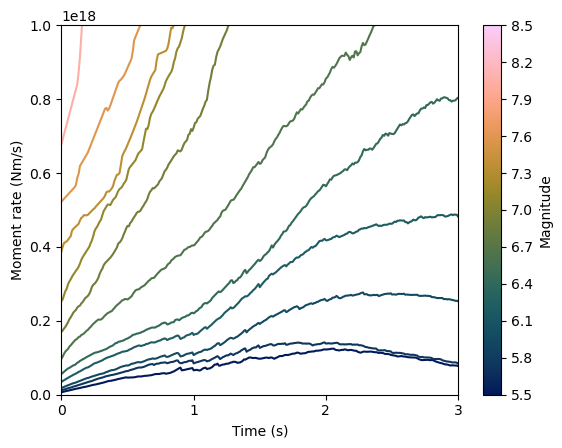

In [27]:
interval = 0.25
boundaries = np.arange(5.5, 8.6, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	UL = b+interval
	if b == 8.5:
		filtered = bigger_than
	else:
		filtered = bigger_than[bigger_than.mag < UL]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	number_of_events = filtered.event.nunique()
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0), label = f'{b:.2f}---{UL:.2f} (N STFs={len(subset)}, Events = {number_of_events})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))
cbar.ax.set_yticklabels([f'{b:.1f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=11)])
cbar.set_label('Magnitude')

# plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 100), np.arange(0, 200, 1))



plt.xlim(0, 300)
plt.ylim(0, 1E18)
# plt.yscale('log')
#plt.legend()


plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_all_mags_zoom.png', bbox_inches = 'tight', dpi = 300)



5.5 0.0205 204
5.8 0.0199 2977
6.0 0.0228 3029
6.2 0.0295 2129
6.5 0.0382 1227
6.8 0.0514 824
7.0 0.0613 434
7.2 0.0903 242
7.5 0.0879 175
7.8 0.2136 111
8.0 0.2069 48
8.2 0.3048 24


/tmp/ipykernel_615670/2303027476.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))


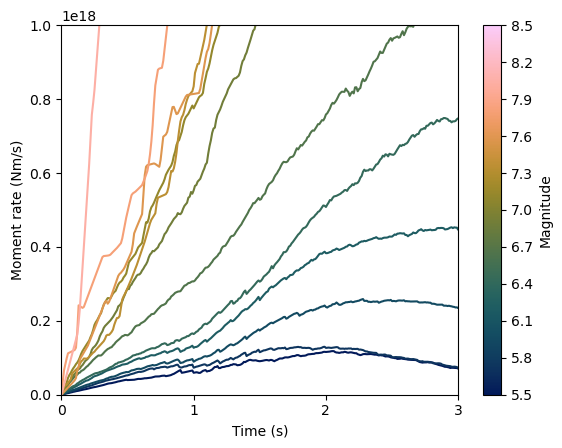

In [28]:
interval = 0.25
boundaries = np.arange(5.5, 8.6, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	UL = b+interval
	if b == 8.5:
		filtered = bigger_than
		continue
	else:
		filtered = bigger_than[bigger_than.mag < UL]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	number_of_events = filtered.event.nunique()
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0)-np.nanmedian(list(subset), axis = 0)[0], label = f'{b:.2f}---{UL:.2f} (N STFs={len(subset)}, Events = {number_of_events})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))
cbar.ax.set_yticklabels([f'{b:.1f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=11)])
cbar.set_label('Magnitude')

# plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 100), np.arange(0, 200, 1))



plt.xlim(0, 300)
plt.ylim(0, 1E18)
# plt.yscale('log')
# plt.legend()


plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_gradient_intercept_corrected.png', bbox_inches = 'tight', dpi = 300)



In [29]:
filtered

event      dataset     mag  \
2879  20120411_0838  scardec_opt  8.6445   
2880  20120411_0838  scardec_moy  8.6445   
2881  20120411_0838         usgs  8.6445   
6383  20100227_0634  scardec_opt  8.7940   
6384  20100227_0634  scardec_moy  8.7940   
6385  20100227_0634           ye  8.7940   
6801  20110311_0546  scardec_opt  9.0260   
6802  20110311_0546  scardec_moy  9.0260   
6803  20110311_0546           ye  9.0260   

                                      interp_momentrate  
2879  [5.42273142e+18, 5.393926161077592e+18, 5.3651...  
2880  [7.81024506e+18, 7.851031862332544e+18, 7.8918...  
2881  [140053790000000.02, 150491230334407.12, 16092...  
6383  [9.87072648e+16, 1.3713756909587482e+17, 1.755...  
6384  [9.57935652e+18, 9.5975269354135e+18, 9.615697...  
6385  [6.6114e+17, 6.743643020251688e+17, 6.87588604...  
6801  [1.30476417e+19, 1.3068999771918938e+19, 1.309...  
6802  [5.44781898e+18, 5.455850715245239e+18, 5.4638...  
6803  [7.3598e+17, 7.506993715756815e+17, 7.65418743...

In [15]:
subset

array([array([5.42273142e+18, 5.39392616e+18, 5.36512090e+18, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([7.81024506e+18, 7.85103186e+18, 7.89181866e+18, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([1.40053790e+14, 1.50491230e+14, 1.60928671e+14, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([9.87072648e+16, 1.37137569e+17, 1.75567873e+17, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([9.57935652e+18, 9.59752694e+18, 9.61569735e+18, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([6.61140000e+17, 6.74364302e+17, 6.87588604e+17, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([1.30476417e+19, 1.30689998e+19, 1.30903578e+19, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([5.44781898e+18, 5.45585072e+18, 5.4638824

In [16]:
np.nanmedian(list(subset), axis = 0)

array([5.42273142e+18, 5.39392616e+18, 5.36512090e+18, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

7.0 0.0613 434
7.2 0.0903 242
7.5 0.0879 175
7.8 0.2136 111
8.0 0.2069 48
8.2 0.3048 24
8.5 0.199 3


/tmp/ipykernel_615670/3958031221.py:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))


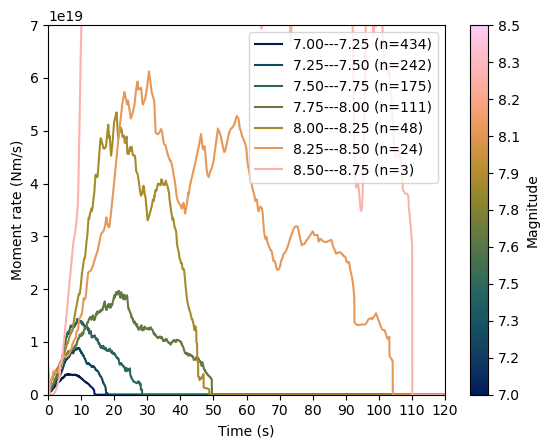

In [30]:
interval = 0.25
boundaries = np.arange(7, 8.6, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
df_interp_ye = df_interp_all
for i, b in enumerate(boundaries):
	bigger_than = df_interp_ye[((df_interp_ye.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0), 
				 label = f'{b:.2f}---{b+interval:.2f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))
cbar.ax.set_yticklabels([f'{b:.1f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=11)])
cbar.set_label('Magnitude')

# plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 1000), np.arange(0, 200, 10))

plt.legend()

plt.xlim(0, 12000)
plt.ylim(0, 7E19)
# plt.ylim(0, max_window)
# plt.yscale('log')
plt.legend()

plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_all_datasets.png', bbox_inches = 'tight', dpi = 300)



7.0 0.0649 35
7.2 0.1012 22
7.5 0.1799 16
7.8 0.2074 12
8.0 0.3399 6
8.2 0.6899 4


/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc5/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/tmp/ipykernel_615670/3461368291.py:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))


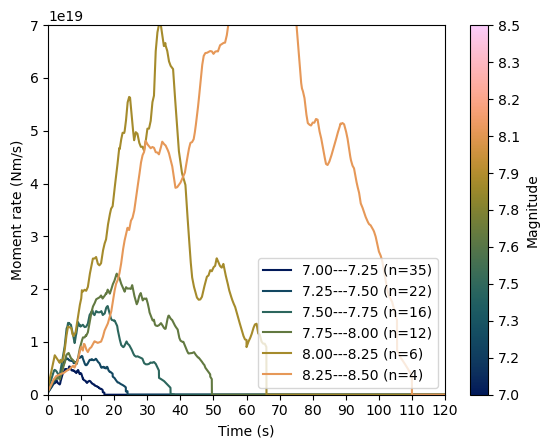

In [31]:
interval = 0.25
boundaries = np.arange(7, 8.6, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
df_interp_ye = df_interp_all[df_interp_all['dataset'].str.contains('ye')]
for i, b in enumerate(boundaries):
	bigger_than = df_interp_ye[((df_interp_ye.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0), 
				 label = f'{b:.2f}---{b+interval:.2f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))
cbar.ax.set_yticklabels([f'{b:.1f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=11)])
cbar.set_label('Magnitude')

# all_data_on_plot = df_interp_ye[((df_interp_ye.mag > min(boundaries)))]
# all_data_on_plot = all_data_on_plot[all_data_on_plot.mag < max(boundaries)]

# print(len(all_data_on_plot), min(boundaries), max(boundaries))

# plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(all_data_on_plot.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 1000), np.arange(0, 200, 10))

plt.legend()

plt.xlim(0, 12000)
plt.ylim(0, 7E19)
# plt.ylim(0, max_window)
# plt.yscale('log')
plt.legend()

plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017.png', bbox_inches = 'tight', dpi = 300)



7.0 0.0649 35
7.2 0.1012 22
7.5 0.1799 16
7.8 0.2074 12
8.0 0.3399 6
8.2 0.6899 4


/tmp/ipykernel_615670/3934573884.py:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))


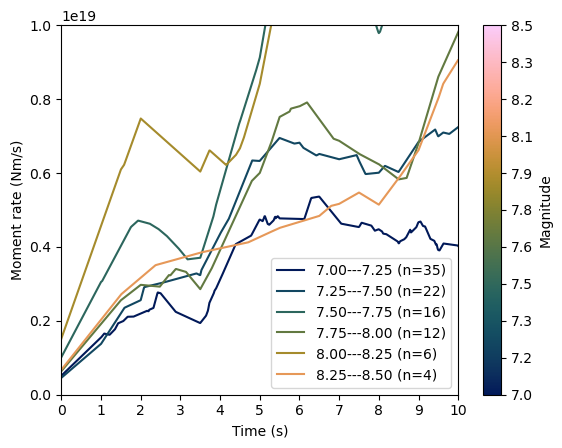

In [32]:
interval = 0.25
boundaries = np.arange(7, 8.6, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
df_interp_ye = df_interp_all[df_interp_all['dataset'].str.contains('ye')]
for i, b in enumerate(boundaries):
	bigger_than = df_interp_ye[((df_interp_ye.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0), 
				 label = f'{b:.2f}---{b+interval:.2f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))
cbar.ax.set_yticklabels([f'{b:.1f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=11)])
cbar.set_label('Magnitude')

#plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 100), np.arange(0, 200, 1))

plt.legend()

plt.xlim(0, 1000)
plt.ylim(0, 1E19)
# plt.ylim(0, max_window)
# plt.yscale('log')
plt.legend()

plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_zoom.png', bbox_inches = 'tight', dpi = 300)



7.0 0.0613 434
7.2 0.0903 242
7.5 0.0879 175
7.8 0.2136 111
8.0 0.2069 48
8.2 0.3048 24
8.5 0.199 3


/tmp/ipykernel_615670/1086923117.py:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))


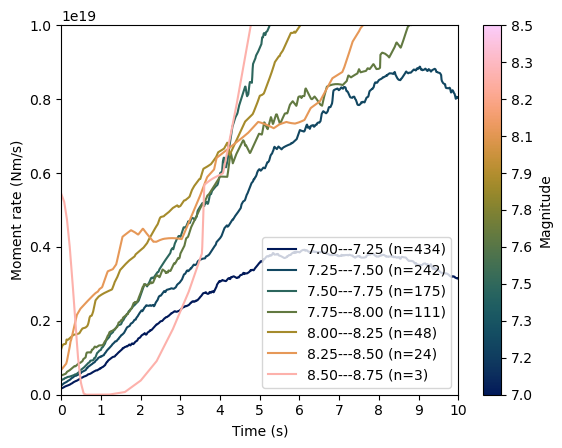

In [33]:
interval = 0.25
boundaries = np.arange(7, 8.6, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
df_interp_ye = df_interp_all
for i, b in enumerate(boundaries):
	bigger_than = df_interp_ye[((df_interp_ye.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0), 
				 label = f'{b:.2f}---{b+interval:.2f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))
cbar.ax.set_yticklabels([f'{b:.1f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=11)])
cbar.set_label('Magnitude')

#plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 100), np.arange(0, 200, 1))

plt.legend()

plt.xlim(0, 1000)
plt.ylim(0, 1E19)
# plt.ylim(0, max_window)
# plt.yscale('log')
plt.legend()

plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_all_datasets_zoom.png', bbox_inches = 'tight', dpi = 300)



5.0 0.0122 5
5.2 0.0094 31
5.5 0.0464 37
5.8 0.0116 34
6.0 0.026 20
6.2 0.0243 10
6.5 0.016 5
6.8 0.054 1


TypeError: 'numpy.float64' object is not iterable

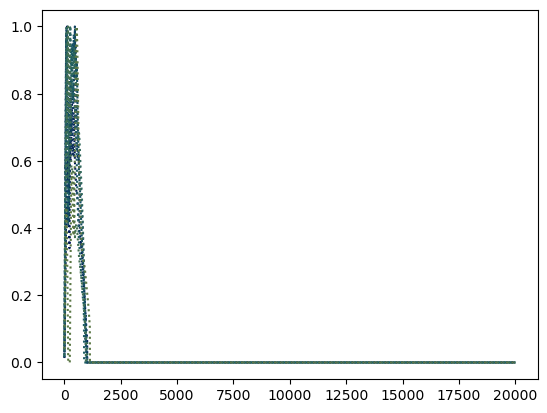

In [123]:
interval = 0.25
boundaries = np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if len(subset) < 100:
		marker = ':'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0)/max(np.nanmedian(list(subset), axis = 0)), label = f'{b:.1f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=11))
cbar.ax.set_yticklabels([f'{b:.1f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=11)])
cbar.set_label('Magnitude')

#plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 1000), np.arange(0, 200, 10))



# plt.xlim(0, 1000)
# #plt.ylim(0, 1E19)
# plt.yscale('log')


plt.ylabel('Normalised moment rate')
plt.xlabel('Normalised time')
#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/median_only_every_025_nolegend_with_overall_median_non_norm.png', bbox_inches = 'tight', dpi = 300)



In [ ]:
subset

array([array([1.30476417e+19, 1.30689998e+19, 1.30903578e+19, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([5.44781898e+18, 5.45585072e+18, 5.46388245e+18, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([7.35980000e+17, 7.50699372e+17, 7.65418743e+17, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ],
      dtype=object)

In [ ]:
len(subset[0])

10000

(array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.4532  , 0.454765, 0.45633 , 0.457895, 0.45946 , 0.461025,
        0.46259 , 0.464155, 0.46572 , 0.467285, 0.46885 , 0.470415,
        0.47198 , 0.473545, 0.47511 , 0.476675, 0.47824 , 0.479805,
        0.48137 , 0.482935, 0.4845  , 0.486065, 0.48763 , 0.489195,
        0.49076 , 0.492325, 0.49389 , 0.495455, 0.49702 , 0.498585,
        0.50015 , 0.501715, 0.50328 , 0.504845, 0.50641 , 0.507975,
        0.50954 , 0.511105, 0.51267 , 0.514235, 0.5158  , 0.517365,
        0.51893 , 0.520495, 0.52206 , 0.523625, 0.52519 , 0.526755,
      

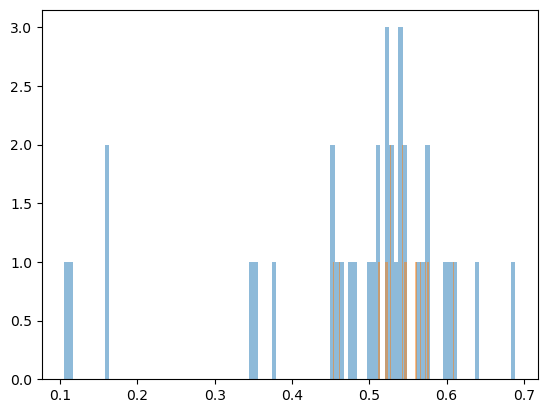

In [ ]:
plt.hist(peak_all, bins = 100, alpha = 0.5, label = 'All')
plt.hist(peak_more_than_100, bins = 100, alpha = 0.5, label = 'More than 100 events')

In [ ]:
min(peak_more_than_100)

0.4532

In [ ]:
max(peak_more_than_100)

0.6097

In [ ]:
np.mean(peak_more_than_100)

0.5355529411764706

In [ ]:
np.median(peak_more_than_100)

0.5426

In [ ]:
np.std(peak_more_than_100)

0.03771812043297677

In [ ]:
np.cumsum(np.nanmedian(list(subset), axis = 0))

array([5.02460088e-03, 1.00948353e-02, 1.52107032e-02, ...,
       4.26940812e+03, 4.26951026e+03, 4.26961227e+03])

2
3
6
15
19
47
95
584
1595
1577
1581
1314
1084
955
691
570
498
354
353
306
238
170
160
92
135
89
73
86
64
41
32
18
14
17
4
0
4
5
0
0
4


/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc5/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc5/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


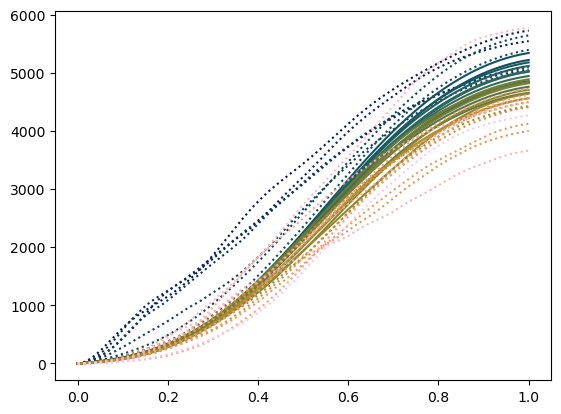

In [ ]:
interval = 0.1
boundaries = np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	print(len(subset))
	if len(subset) < 100:
		marker = ':'
	else:
		marker = '-'

	cumsum = np.cumsum(np.nanmedian(list(subset), axis = 0))
	if len(cumsum) > 1:
		plt.plot(np.linspace(0, 1, 10000), cumsum, label = f'{b:.1f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker)


	#plt.title(f'Events M{b:.1f} --- {b+0.1:.1f}')

	#plt.show()
#plt.legend()

#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/median_only_every_01_nolegend.png', bbox_inches = 'tight', dpi = 300)



In [ ]:
df_interp

event      dataset    mag  \
0      20170818_0259  scardec_opt  6.591   
1      20170818_0259  scardec_moy  6.591   
2      20110126_1542  scardec_opt  6.114   
3      20110126_1542  scardec_moy  6.114   
4      20110126_1542    sigloch_0  6.114   
...              ...          ...    ...   
12959  20230206_1024         usgs    NaN   
12960  20231202_1437         usgs    NaN   
12961  19971108_1002         usgs    NaN   
12962  20181220_1701         usgs    NaN   
12963  20240628_0536         usgs    NaN   

                                       interp_momentrate  
0      [0.025571430582375584, 0.02580713208922849, 0....  
1      [0.0649328959491289, 0.06495836901862619, 0.06...  
2      [0.02442497978026939, 0.0246171867196723, 0.02...  
3      [0.005022598858295051, 0.005007530833759215, 0...  
4      [0.05504004749655065, 0.05511206329948409, 0.0...  
...                                                  ...  
12959  [2.4688726296868274e-07, 5.827989128186977e-07...  
12960  [1.0173933482195323e-07, 2.219968359510766e-07...  
12961  [0.0011436355847583152, 0.0011974800886728725,...  
12962  [0.003668254736710576, 0.0038283515561107523, ...  
12963  [3.1444127236704575e-07, 5.479736629066098e-07...  

[12964 rows x 4 columns]

25
56
584
1595
1577
1581
1314
1084
955
691
570
498
354
353
306
238
170
160
92
135
89
73
86
64
41
32
18
14
17
4
0
false
4
5
0
false
0
false
4


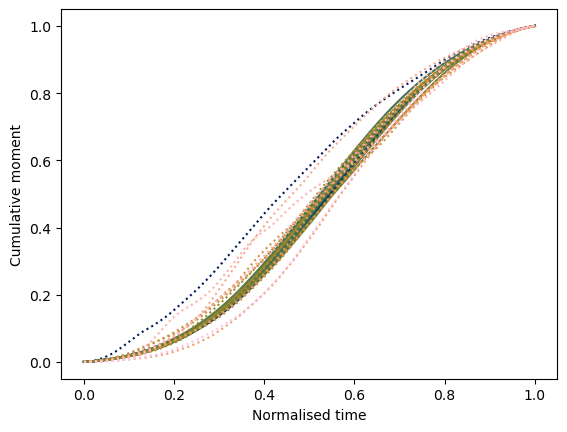

In [ ]:
interval = 0.1
boundaries = np.arange(5.5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	print(len(subset))
	if len(subset) < 100:
		marker = ':'
	else:
		marker = '-'

	if type(np.nanmedian(list(subset), axis = 0)) is np.ndarray:
		moment = scipy.integrate.cumtrapz(np.nanmedian(list(subset), axis = 0))[-1]
		#if np.isnan(np.nanmedian(list(subset), axis = 0)) is not True:
		cumsum = scipy.integrate.cumtrapz(np.nanmedian(list(subset), axis = 0))#, np.linspace(0, 1, 10000))
		plt.plot(np.linspace(0, 1, 9999), cumsum/moment, label = f'{b:.1f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker)
	else:
		print('false')

plt.ylabel('Cumulative moment')
plt.xlabel('Normalised time')

	#plt.title(f'Events M{b:.1f} --- {b+0.1:.1f}')

#plt.show()
#plt.legend()

plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/cumulative_moment_for_median_stf.png')



25
56
584
1595
1577
1581
1314
1084
955
691
570
498
354
353
306
238
170
160
92
135
89
73
86
64
41
32
18
14
17
4
0
false
4
5
0
false
0
false
4


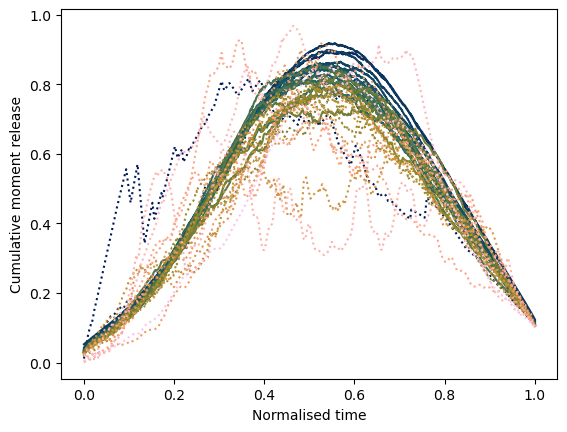

In [ ]:
interval = 0.1
boundaries = np.arange(5.5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	print(len(subset))
	if len(subset) < 100:
		marker = ':'
	else:
		marker = '-'

	if type(np.nanmedian(list(subset), axis = 0)) is np.ndarray:
		#if np.isnan(np.nanmedian(list(subset), axis = 0)) is not True:
		cumsum = np.nanmedian(list(subset), axis = 0)#, np.linspace(0, 1, 10000))
		plt.plot(np.linspace(0, 1, 10000), cumsum, label = f'{b:.1f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker)
	else:
		print('false')

plt.ylabel('Cumulative moment release')
plt.xlabel('Normalised time')

	#plt.title(f'Events M{b:.1f} --- {b+0.1:.1f}')

plt.show()
#plt.legend()

#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/median_only_every_01_nolegend.png')



25
56
584
1595
1577
1581
1314
1084
955
691
570
498
354
353
306
238
170
160
92
135
89
73
86
64
41
32
18
14
17
4
0
false
4
5
0
false
0
false
4


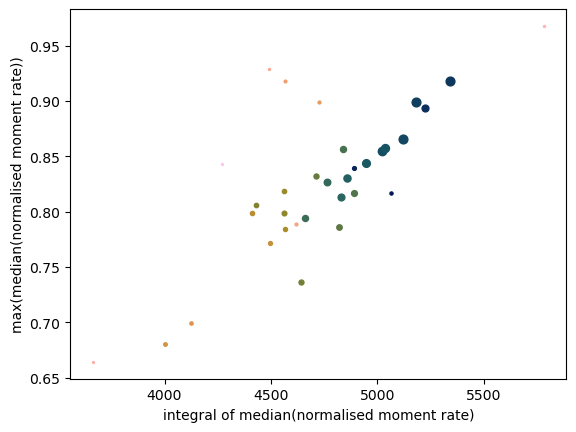

In [ ]:
interval = 0.1
boundaries = np.arange(5.5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	print(len(subset))
	if len(subset) < 100:
		marker = ':'
	else:
		marker = '-'

	if type(np.nanmedian(list(subset), axis = 0)) is np.ndarray:
		moment = scipy.integrate.cumtrapz(np.nanmedian(list(subset), axis = 0))[-1]
		#if np.isnan(np.nanmedian(list(subset), axis = 0)) is not True:
		#cumsum = scipy.integrate.cumtrapz(np.nanmedian(list(subset), axis = 0))#, np.linspace(0, 1, 10000))
		plt.scatter(moment, max(np.nanmedian(list(subset), axis = 0)), label = f'{b:.1f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], s = np.sqrt(len(subset)))#, linestyle = marker)
	else:
		print('false')

plt.ylabel('max(median(normalised moment rate))')
plt.xlabel('integral of median(normalised moment rate)')

	#plt.title(f'Events M{b:.1f} --- {b+0.1:.1f}')

#plt.show()
#plt.legend()

plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/peak_mr_vs_integral_of_mr.png')



In [ ]:
subset

array([array([0.02861027, 0.02875576, 0.02890125, ..., 0.18984658, 0.18955574,
              0.1892649 ])                                                    ,
       array([0.00249939, 0.00249553, 0.00249166, ..., 0.1243579 , 0.12395533,
              0.12355276])                                                    ,
       array([0.03837141, 0.03848262, 0.03859383, ..., 0.18155049, 0.18127032,
              0.18099015])                                                    ,
       array([0.00053624, 0.00053415, 0.00053207, ..., 0.11345617, 0.11323612,
              0.11301606])                                                    ,
       array([0.0273875 , 0.02795875, 0.02853   , ..., 0.14182532, 0.14119384,
              0.14056237])                                                    ,
       array([0.12244574, 0.12240873, 0.12237172, ..., 0.12908484, 0.12866077,
              0.12823669])                                                    ,
       array([0.0435288 , 0.04394893, 0.044369

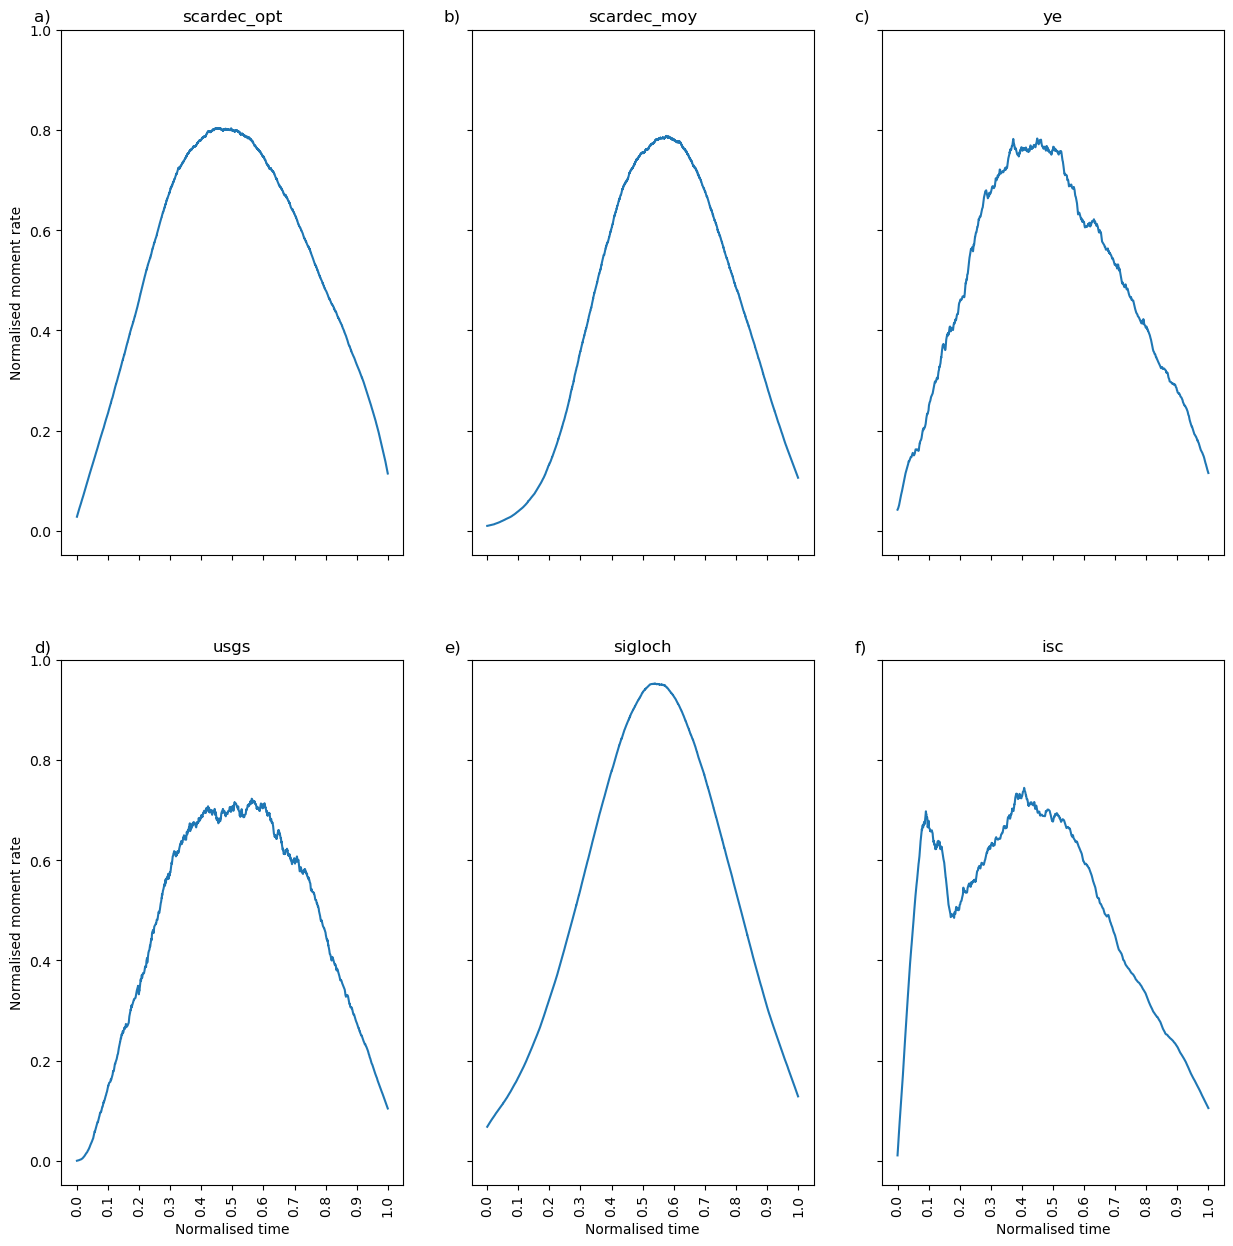

In [ ]:
ticks = np.arange(0, 1.1, 0.1)
ticks = list(map(lambda x: round(x, 1), ticks))

fig, axs = plt.subplots(2, 3, figsize=(15, 15), sharex = True, sharey = True)

for i, dataset in enumerate(['scardec_opt', 'scardec_moy', 'ye', 'usgs', 'sigloch', 'isc']):
	df_interp = df_interp_all[df_interp_all['dataset'].str.contains(dataset)]

	ax = axs[i//3, i%3]
	subset = df_interp.interp_momentrate.values
	# for s in subset:
	# 	ax.plot(s, color = 'grey', alpha = 0.05)
	ax.plot(np.median(list(subset), axis = 0), label = f'Events {dataset}')
	ax.set_title(f'{dataset}')

	ax.set_xticks(np.linspace(0, 10000, 11), ticks, rotation = 90)
	#ax.legend(loc = 'upper right')

	if i%3 == 0:
		ax.set_ylabel('Normalised moment rate')
	if i//3 == 1:
		ax.set_xlabel('Normalised time')		
import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(-20 / 72, 4 / 72, fig.dpi_scale_trans)
axs[0][0].text(0.0, 1.0, 'a)', transform=axs[0][0].transAxes + trans,
				fontsize='12', va='bottom')
axs[0][1].text(0.0, 1.0, 'b)', transform=axs[0][1].transAxes + trans,
				fontsize='12', va='bottom')
axs[0][2].text(0.0, 1.0, 'c)', transform=axs[0][2].transAxes + trans,
				fontsize='12', va='bottom')
axs[1][0].text(0.0, 1.0, 'd)', transform=axs[1][0].transAxes + trans,
				fontsize='12', va='bottom')
axs[1][1].text(0.0, 1.0, 'e)', transform=axs[1][1].transAxes + trans,
				fontsize='12', va='bottom')
axs[1][2].text(0.0, 1.0, 'f)', transform=axs[1][2].transAxes + trans,
				fontsize='12', va='bottom')

plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/median_stf_by_dataset.png', bbox_inches='tight')
plt.show()
	#plt.close()


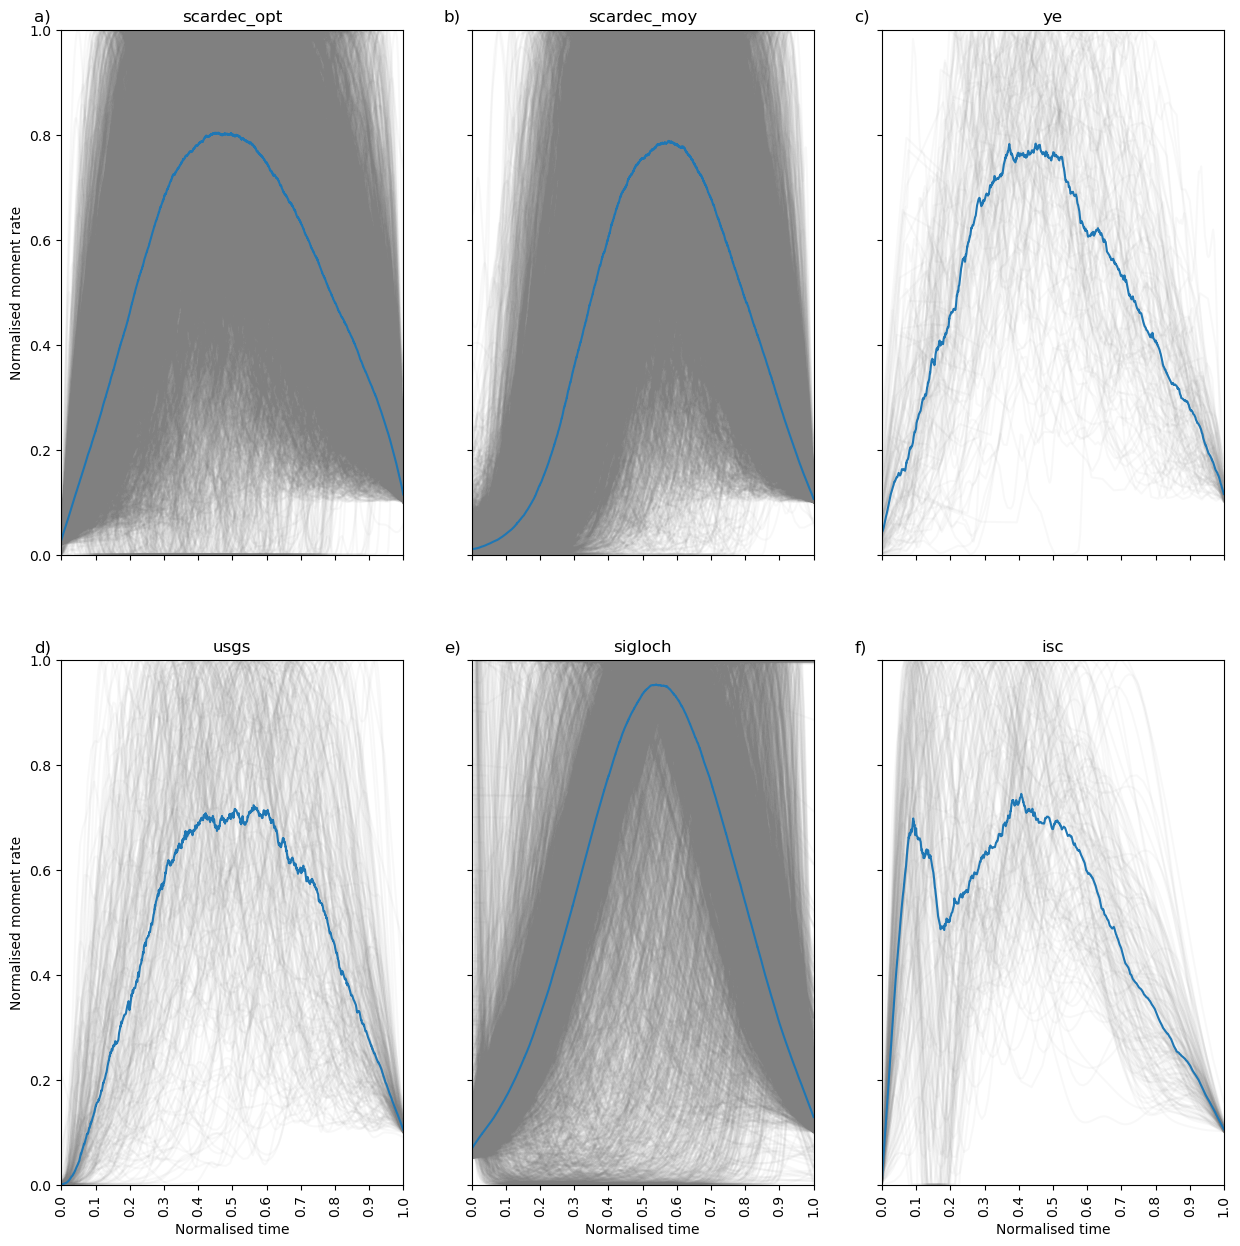

In [ ]:
ticks = np.arange(0, 1.1, 0.1)
ticks = list(map(lambda x: round(x, 1), ticks))

fig, axs = plt.subplots(2, 3, figsize=(15, 15), sharex = True, sharey = True)

for i, dataset in enumerate(['scardec_opt', 'scardec_moy', 'ye', 'usgs', 'sigloch', 'isc']):
	df_interp = df_interp_all[df_interp_all['dataset'].str.contains(dataset)]

	ax = axs[i//3, i%3]
	subset = df_interp.interp_momentrate.values
	for s in subset:
		ax.plot(s, color = 'grey', alpha = 0.05)
	ax.plot(np.median(list(subset), axis = 0), label = f'Events {dataset}')
	ax.set_title(f'{dataset}')

	ax.set_xticks(np.linspace(0, 10000, 11), ticks, rotation = 90)
	ax.set_ylim(0, 1)
	ax.set_xlim(0, 10000)
	#ax.legend(loc = 'upper right')

	if i%3 == 0:
		ax.set_ylabel('Normalised moment rate')
	if i//3 == 1:
		ax.set_xlabel('Normalised time')

		# Add figure panel labels

import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(-20 / 72, 4 / 72, fig.dpi_scale_trans)
axs[0][0].text(0.0, 1.0, 'a)', transform=axs[0][0].transAxes + trans,
				fontsize='12', va='bottom')
axs[0][1].text(0.0, 1.0, 'b)', transform=axs[0][1].transAxes + trans,
				fontsize='12', va='bottom')
axs[0][2].text(0.0, 1.0, 'c)', transform=axs[0][2].transAxes + trans,
				fontsize='12', va='bottom')
axs[1][0].text(0.0, 1.0, 'd)', transform=axs[1][0].transAxes + trans,
				fontsize='12', va='bottom')
axs[1][1].text(0.0, 1.0, 'e)', transform=axs[1][1].transAxes + trans,
				fontsize='12', va='bottom')
axs[1][2].text(0.0, 1.0, 'f)', transform=axs[1][2].transAxes + trans,
				fontsize='12', va='bottom')
#plt.tight_layout()

plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/median_stf_by_dataset_and_all_data.png', bbox_inches='tight')
plt.show()
	#plt.close()


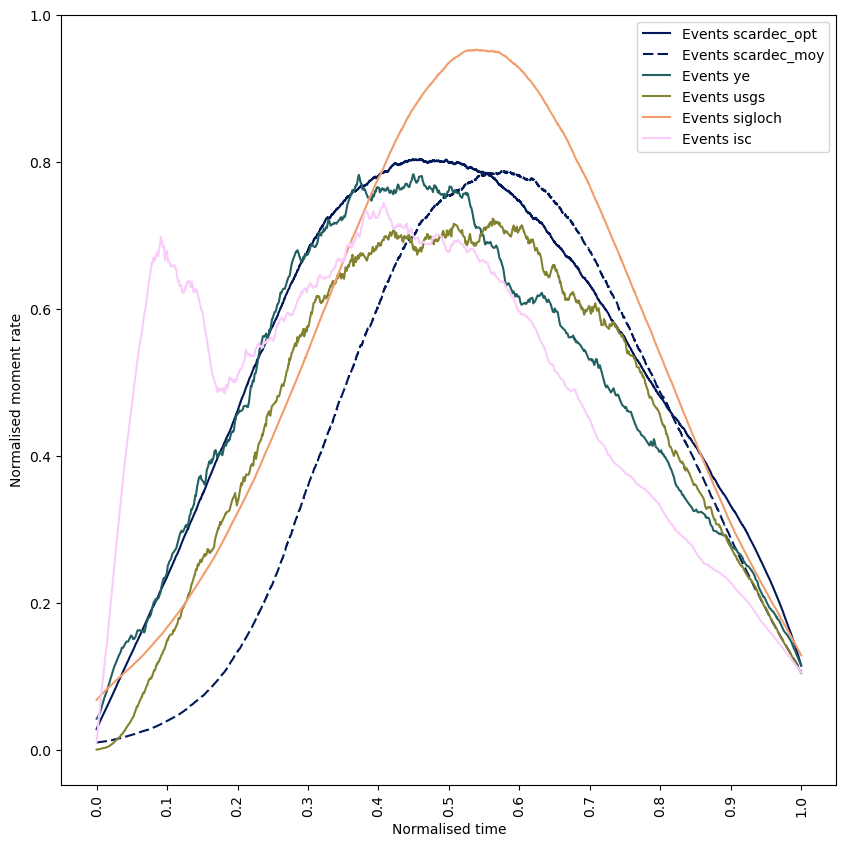

In [ ]:
ticks = np.arange(0, 1.1, 0.1)
ticks = list(map(lambda x: round(x, 1), ticks))

fig, axs = plt.subplots(1, 1, figsize=(10, 10), sharex = True, sharey = True)

colors = cmc.batlow(np.linspace(0, 1, 5))

for i, dataset in enumerate(['scardec_opt', 'scardec_moy', 'ye', 'usgs', 'sigloch', 'isc']):
	df_interp = df_interp_all[df_interp_all['dataset'].str.contains(dataset)]

	ax = axs
	subset = df_interp.interp_momentrate.values
	# for s in subset:
	# 	ax.plot(s, color = 'grey', alpha = 0.05)
	if i > 1 : 
		ax.plot(np.median(list(subset), axis = 0), label = f'Events {dataset}', color = colors[i-1], linestyle = 'solid')
	elif i == 1:
		ax.plot(np.median(list(subset), axis = 0), label = f'Events {dataset}', color = colors[i-1], linestyle = (0, (5,2)))
	else:
		ax.plot(np.median(list(subset), axis = 0), label = f'Events {dataset}', color = colors[i], linestyle = 'solid')
	#ax.set_title(f'{dataset}')

ax.set_xticks(np.linspace(0, 10000, 11), ticks, rotation = 90)
#ax.legend(loc = 'upper right')

ax.set_ylabel('Normalised moment rate')
ax.set_xlabel('Normalised time')		

plt.legend()

plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/median_stf_by_dataset_all_on_one.png', bbox_inches='tight', dpi=300)
plt.show()
	#plt.close()


In [ ]:
for i, dataset in enumerate(['scardec_opt', 'scardec_moy', 'ye', 'usgs', 'sigloch', 'isc']):
	df_interp = df_interp_all[df_interp_all['dataset'].str.contains(dataset)]
	median_stf = np.median(list(subset), axis = 0)
	subset = df_interp.interp_momentrate.values
	print(dataset)
	print(np.argmax(median_stf))
	

scardec_opt
4073
scardec_moy
4494
ye
5761
usgs
4497
sigloch
5622
isc
5399


In [ ]:
np.mean(np.median(list(subset), axis = 0))

0.4959666807054781